# Credit Scorecard Notebook
- Author: Marcellinus Aditya Witarsah
- Date: 19 May 2024

In [116]:
# Imports
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from scipy import stats
from typing import Tuple
from typing import Union
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.calibration import calibration_curve


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# About the Data
Table information about the dataset from [Kaggle](https://www.kaggle.com/datasets/laotse/credit-risk-dataset).
|      **Feature Name**      |               **Description**               |
|:--------------------------:|:-------------------------------------------:|
| person_age                 | Age                                         |
| person_income              | Annual Income                               |
| person_home_ownership      | Home ownership                              |
| person_emp_length          | Employment length (in years)                |
| loan_intent                | Loan intent                                 |
| loan_grade                 | Loan grade                                  |
| loan_amnt                  | Loan amount                                 |
| loan_int_rate              | Interest rate                               |
| loan_status                | Loan status (0 is non default 1 is default) |
| loan_percent_income        | Percent income                              |
| cb_person_default_on_file  | Historical default                          |
| cb_preson_cred_hist_length | Credit history length                       |

# Load Data

In [9]:
# Load and inspect data
df = pd.read_csv("../data/raw/credit_risk_dataset.csv")
display(df.head())
display(df.info())
display(df.describe())

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


None

person_age  person_income  person_emp_length     loan_amnt  \
count  32581.000000   3.258100e+04       31686.000000  32581.000000   
mean      27.734600   6.607485e+04           4.789686   9589.371106   
std        6.348078   6.198312e+04           4.142630   6322.086646   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.850000e+04           2.000000   5000.000000   
50%       26.000000   5.500000e+04           4.000000   8000.000000   
75%       30.000000   7.920000e+04           7.000000  12200.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   29465.000000  32581.000000         32581.000000   
mean       11.011695      0.218164             0.170203   
std         3.240459      0.413006             0.106782   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000             0.090000   
50%        10.990000      0.000000             0.150000   
75%        13.470000      0.000000             0.230000   
max        23.220000      1.000000             0.830000   

       cb_person_cred_hist_length  
count                32581.000000  
mean                     5.804211  
std                      4.055001  
min                      2.000000  
25%                      3.000000  
50%                      4.000000  
75%                      8.000000  
max                     30.000000

# Exploratory Data Analysis

## Univariate Analysis

### Target Proportion

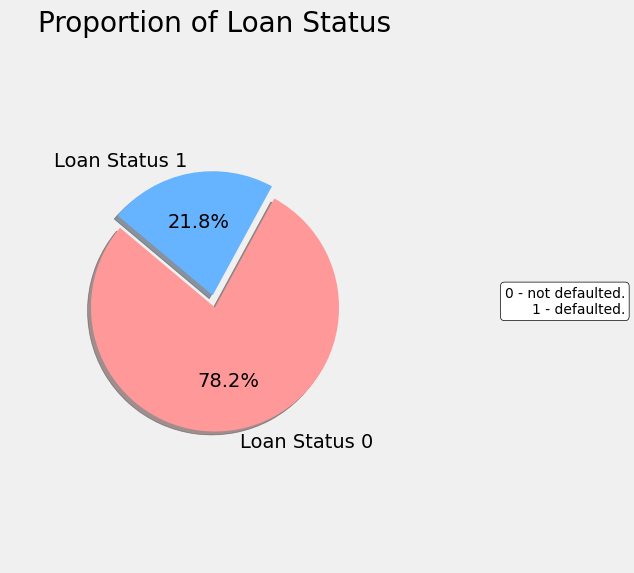

In [3]:
plt.style.use('fivethirtyeight')

# Count the values of "loan_status"
loan_status_counts = df["loan_status"].value_counts()

# Create labels and sizes for the pie chart
labels = ["Loan Status 0", "Loan Status 1"]
sizes = [loan_status_counts[0], loan_status_counts[1]]
colors = ["#ff9999","#66b3ff"]
explode = (0.1, 0)  # explode the 1st slice (Loan Status 0)

# Create the pie chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=140)
ax.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add a title
plt.title("Proportion of Loan Status")

# Add annotation
annotation = (
    "0 - not defaulted.\n"
    "1 - defaulted."
)
plt.annotate(annotation, xy=(1, 0.5), xytext=(1.5, 0.5),
    textcoords="axes fraction", ha="right", va="center", fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
)

# Show the plot
plt.tight_layout()
plt.show()

### Missing Values

In [4]:
# Count percentage missing values
missing_values_count = df.isna().sum()
missing_values_count / len(df) * 100

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             2.747000
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_int_rate                 9.563856
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

### Numerical

In [5]:
def plot_hist_box(df: pd.DataFrame, numerical_column: str) -> None:
    """
    Show distribution of numerical data by histogram plot and boxplot.
    
    Parameters
    ------------
        df (pd.DataFrame): The dataframe containing the data.
        numerical_column (str): numerical columns to be plotted
    Returns
    ------------
        None
    """
    _, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with 1 row and 2 columns

    # Histogram
    df[numerical_column].hist(ax=axes[0], bins=30, edgecolor='black')
    axes[0].set_title(f"Histogram of {numerical_column}")
    axes[0].set_xlabel(numerical_column)
    axes[0].set_ylabel("Frequency")

    # Boxplot
    df.boxplot(column=numerical_column, ax=axes[1])
    axes[1].set_title(f"Boxplot of {numerical_column}")
    axes[1].set_xlabel(numerical_column)
    axes[1].set_ylabel("Value")

    # Show plots
    plt.tight_layout()
    plt.show()

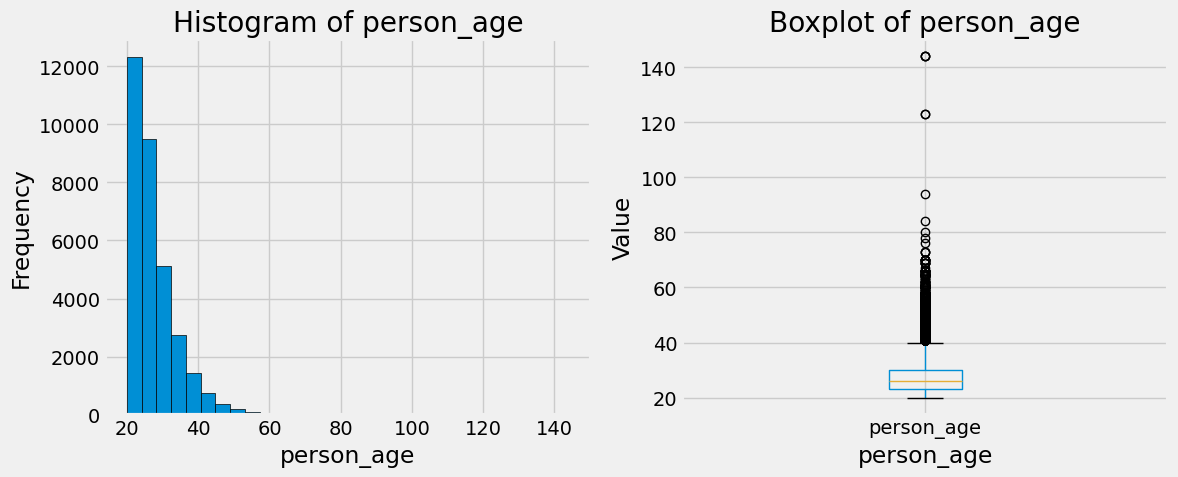

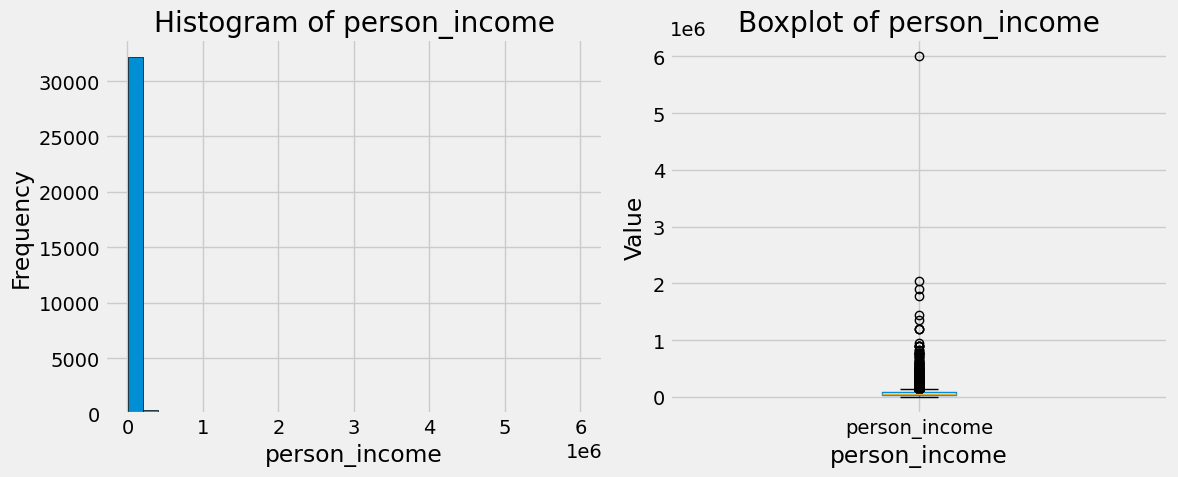

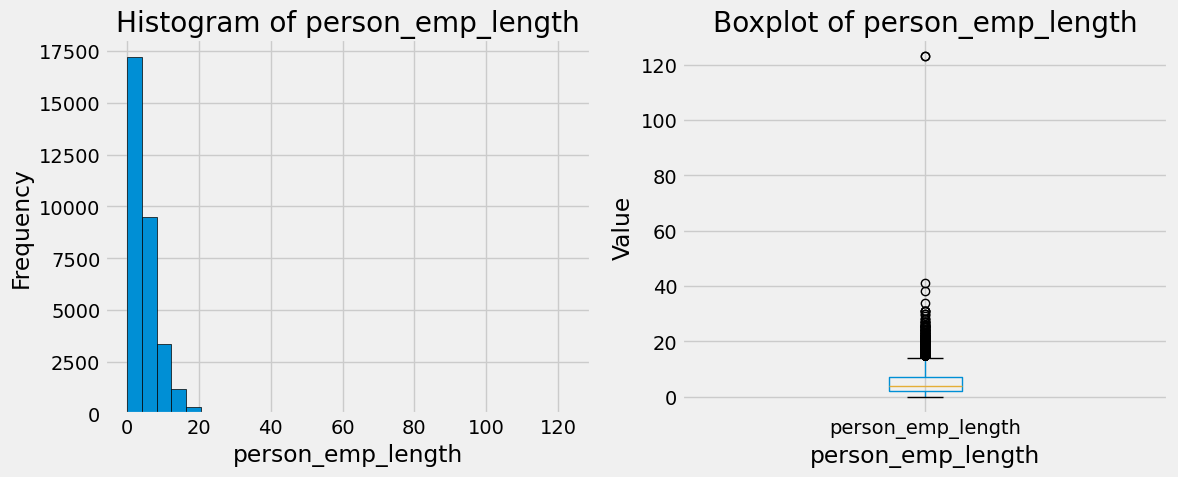

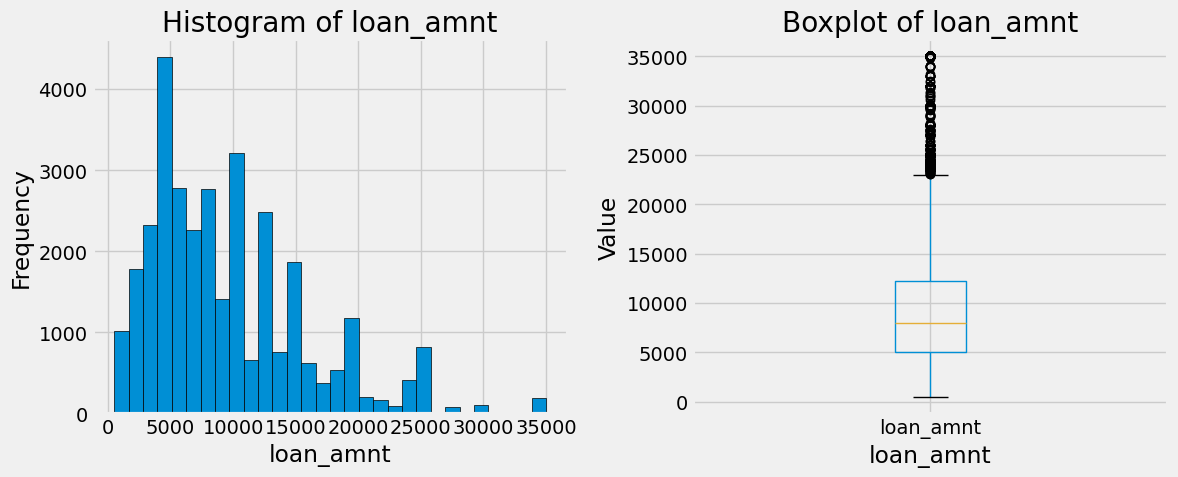

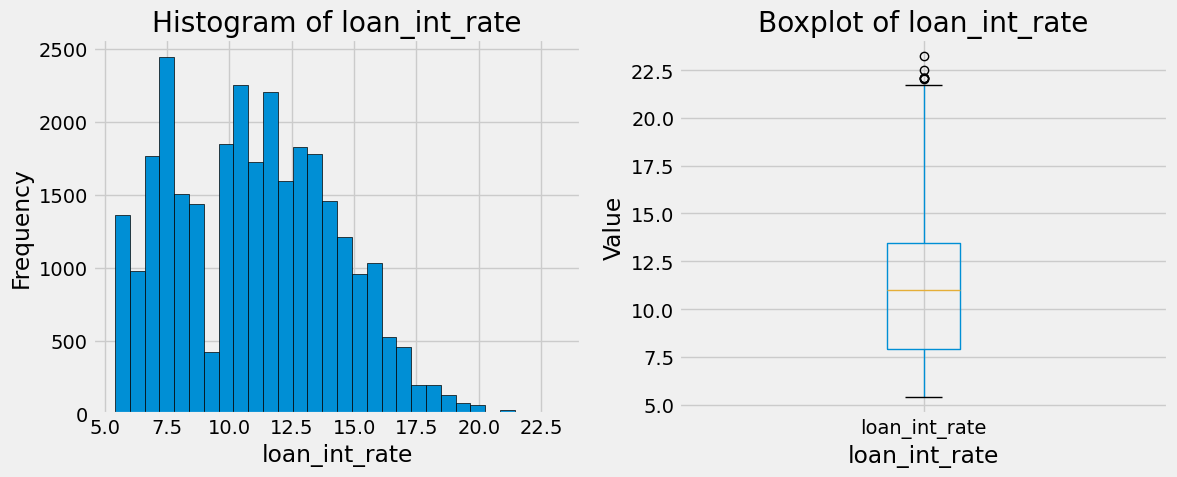

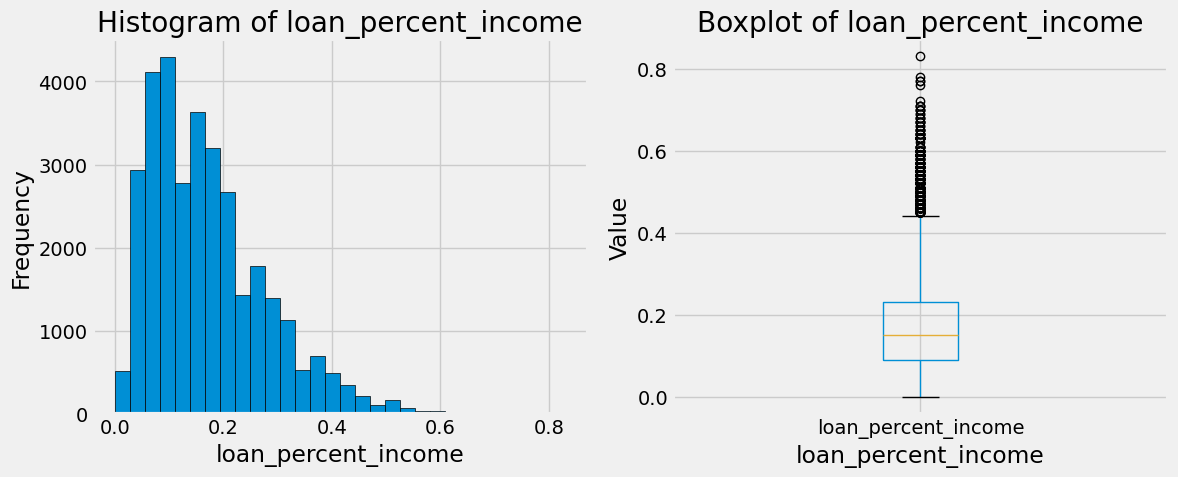

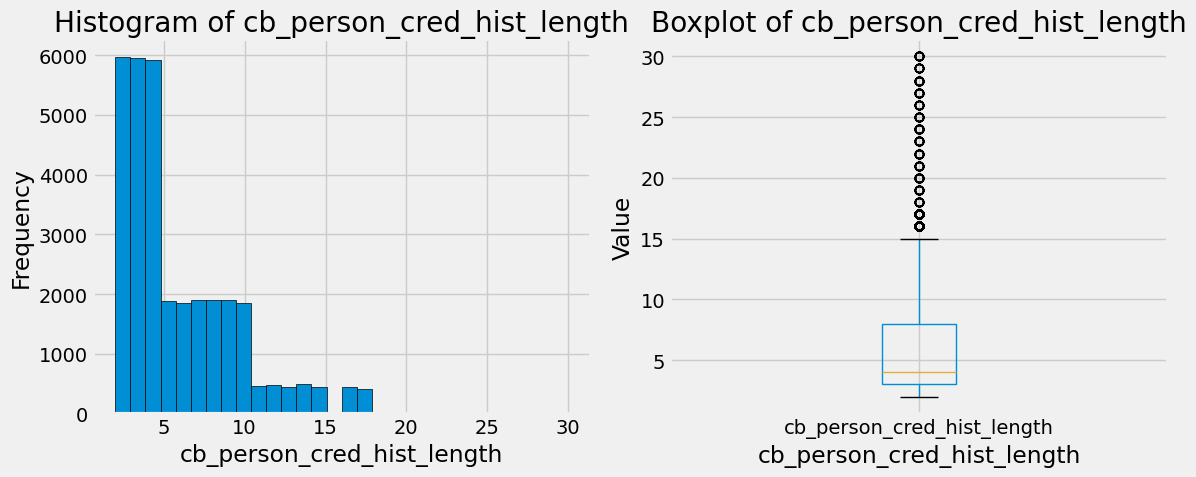

In [6]:
# Plot histogram and boxplot
numerical_columns = df.select_dtypes("number").columns  # Get the numerical columns

plt.style.use('fivethirtyeight')
for numerical_column in numerical_columns:
    if numerical_column != "loan_status":
        plot_hist_box(df, numerical_column)

Suspected outliers inside of the `person_age` where the longest people who ever lived was 122 years old.

In [7]:
df[df["person_age"] > 120]

person_age  person_income person_home_ownership  person_emp_length  \
81            144         250000                  RENT                4.0   
183           144         200000              MORTGAGE                4.0   
575           123          80004                  RENT                2.0   
747           123          78000                  RENT                7.0   
32297         144        6000000              MORTGAGE               12.0   

      loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
81        VENTURE          C       4800          13.57            0   
183     EDUCATION          B       6000          11.86            0   
575     EDUCATION          B      20400          10.25            0   
747       VENTURE          B      20000            NaN            0   
32297    PERSONAL          C       5000          12.73            0   

       loan_percent_income cb_person_default_on_file  \
81                    0.02                         N   
183                   0.03                         N   
575                   0.25                         N   
747                   0.26                         N   
32297                 0.00                         N   

       cb_person_cred_hist_length  
81                              3  
183                             2  
575                             3  
747                             4  
32297                          25

Looking at the data the numbers seems authentic. But in real life we might need to confirm about this.

### Categorical

In [8]:
def plot_count_categorical(df: pd.DataFrame, categorical_column: str) -> None:
    """
    Show number of occurences of each categorical column.
    
    Parameters
    ------------
        df (pd.DataFrame): The dataframe containing the data.
        numerical_column (str): The numerical column to be plotted.
        categorical_column (str): categorical columns to be plotted
    Returns
    ------------
        None
    """
    _, ax = plt.subplots(figsize=(8, 6))  # Create a figure

    # Bar plot
    df[categorical_column].value_counts().plot(kind='barh', ax=ax, edgecolor='black')
    ax.set_title(f"Count of {categorical_column}")
    ax.set_xlabel(categorical_column)
    ax.set_ylabel("Count")

    # Show plot
    plt.tight_layout()
    plt.show()

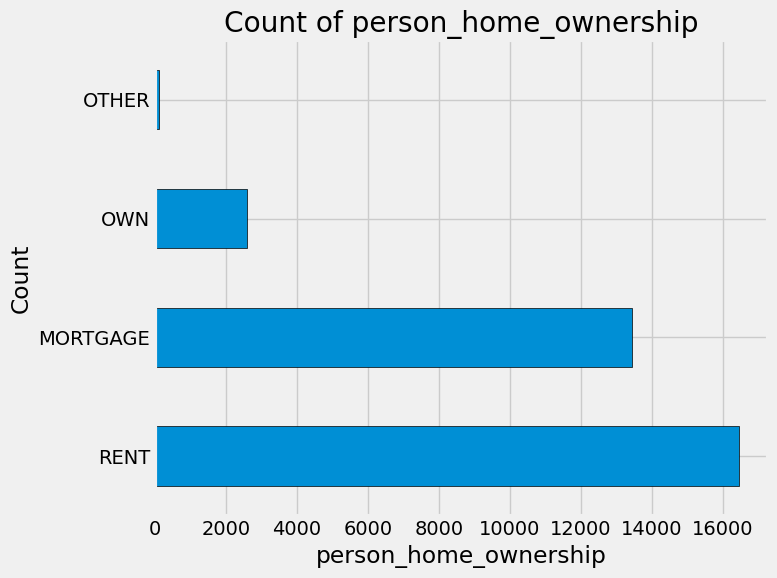

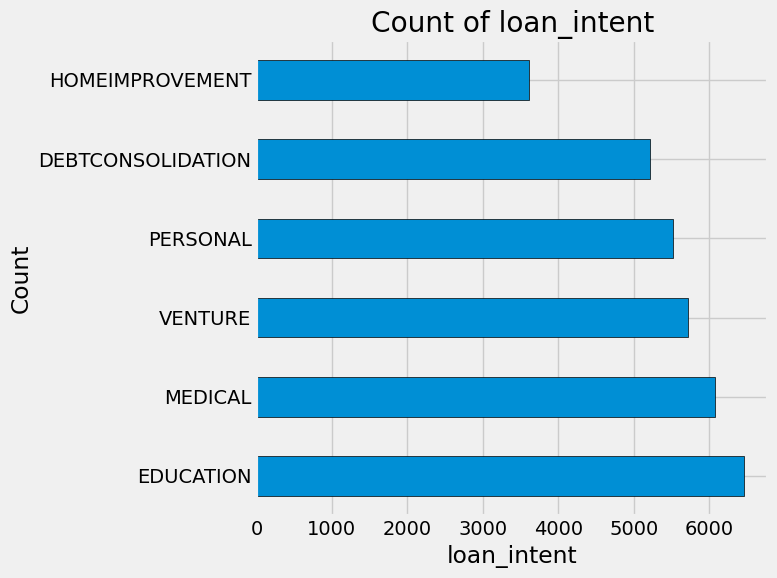

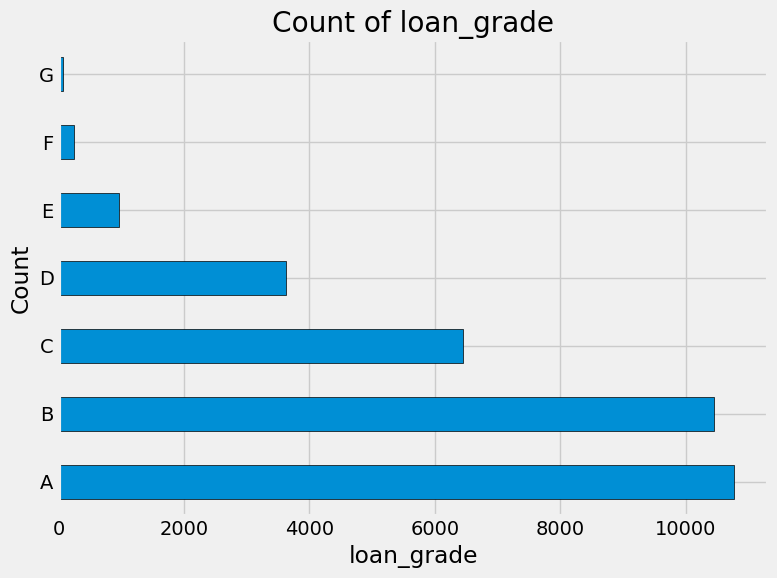

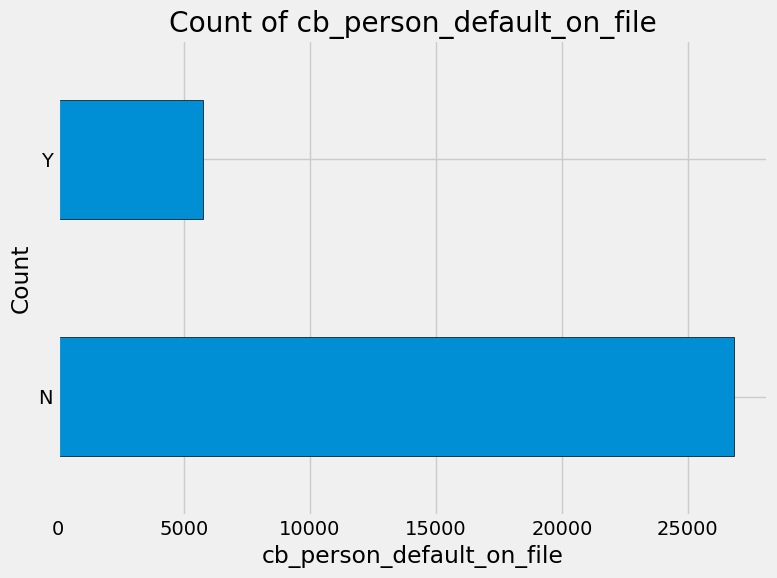

In [9]:
categorical_columns = df.select_dtypes("object").columns  # Get categorical columns

plt.style.use('fivethirtyeight')
for categorical_column in categorical_columns:
    plot_count_categorical(df, categorical_column)

## Multivariate Analysis

### Numerical vs Target

In [10]:
def plot_dist_numerical_by_target(df: pd.DataFrame, numerical_column: str, target_column: str) -> None:
    """
    Show distribution and boxplot of a numerical column, grouped by a target column.
    
    Parameters
    ------------
        df (pd.DataFrame): The dataframe containing the data.
        numerical_column (str): The numerical column to be plotted.
        target_column (str): The target column for grouping.
    Returns
    ------------
        None
    """
    _, axes = plt.subplots(1, 2, figsize=(14, 6))  # Create a figure with 1 row and 2 columns

    # KDE plot with hue
    for target_value in df[target_column].unique():
        sns.kdeplot(data=df[df[target_column]==target_value], x=numerical_column, ax=axes[0], label=f"{target_column} {target_value}")
    axes[0].set_title(f"Distribution of {numerical_column} by {target_column}")
    axes[0].set_xlabel(numerical_column)
    axes[0].set_ylabel("Density")
    axes[0].legend()

    # Boxplot with hue
    sns.boxplot(data=df, x=target_column, y=numerical_column, ax=axes[1])
    axes[1].set_title(f"Boxplot of {numerical_column} by {target_column}")
    axes[1].set_xlabel(target_column)
    axes[1].set_ylabel(numerical_column)

    # Show plots
    plt.tight_layout()
    plt.show()


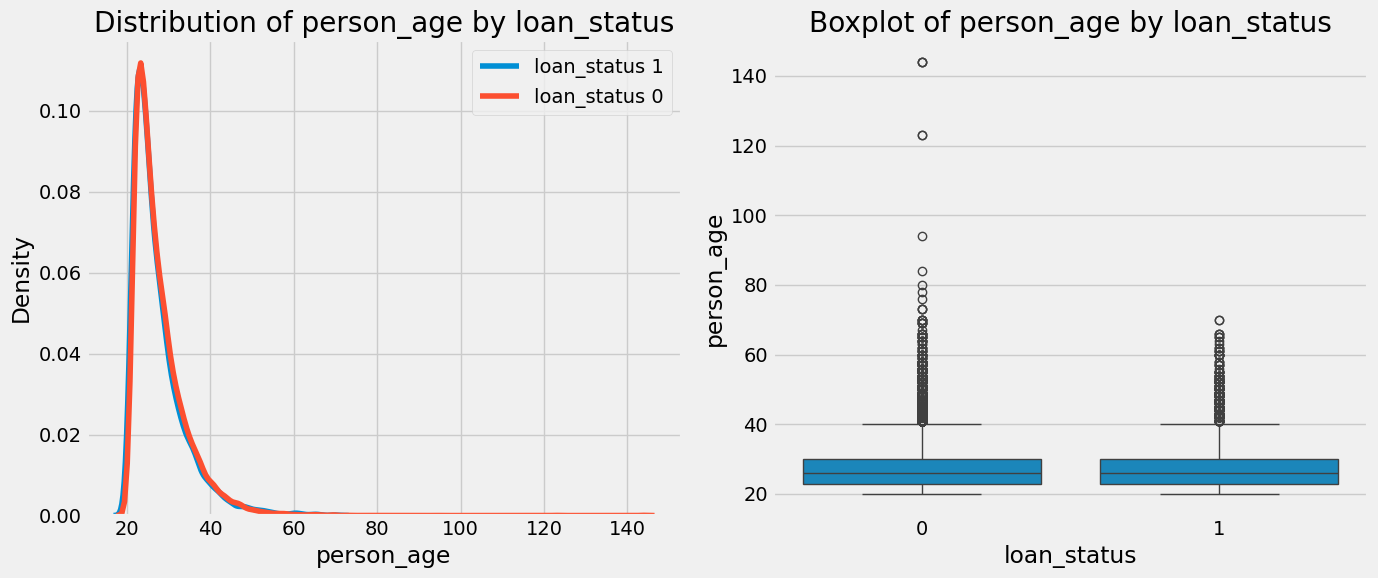

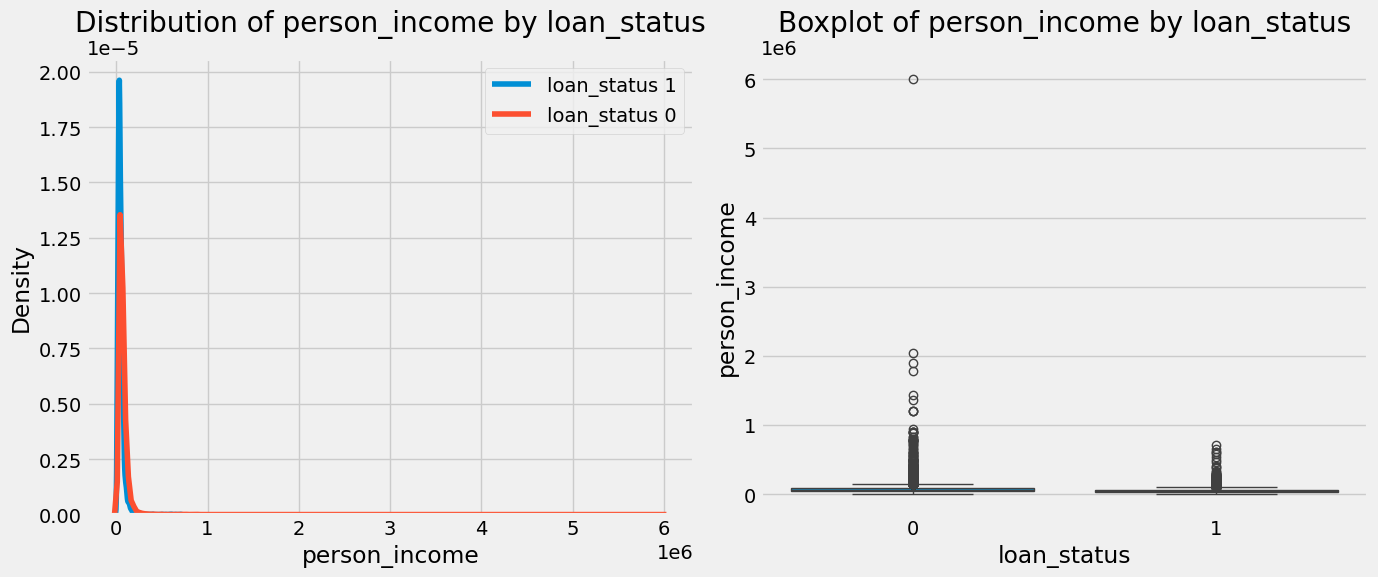

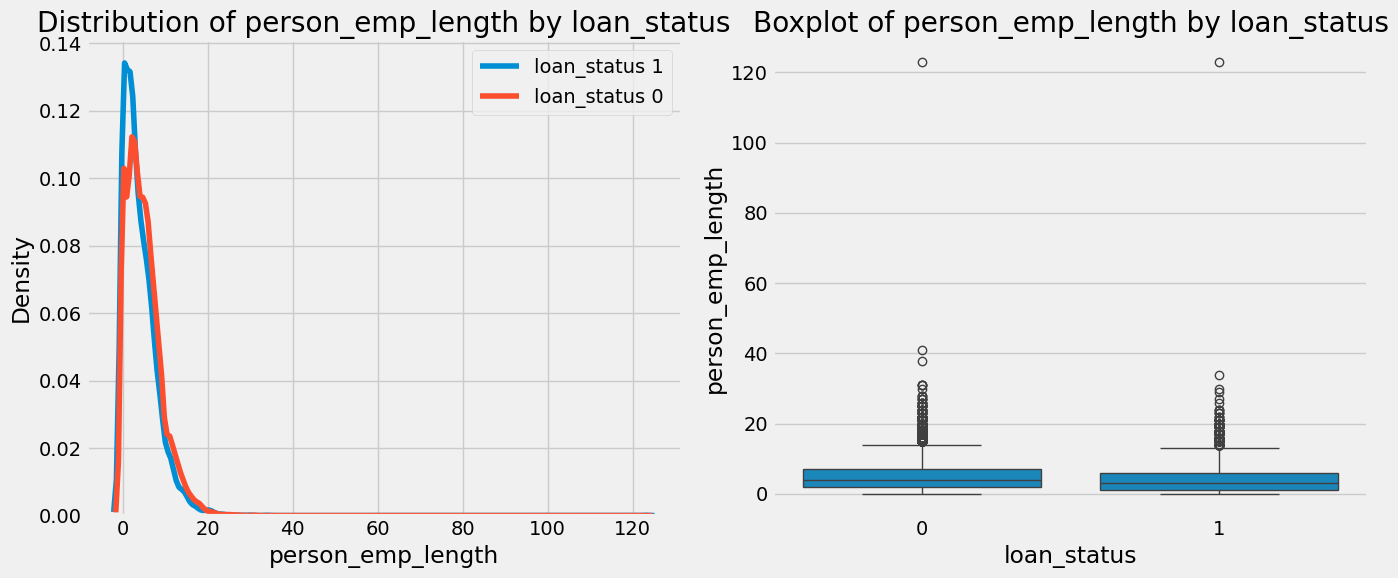

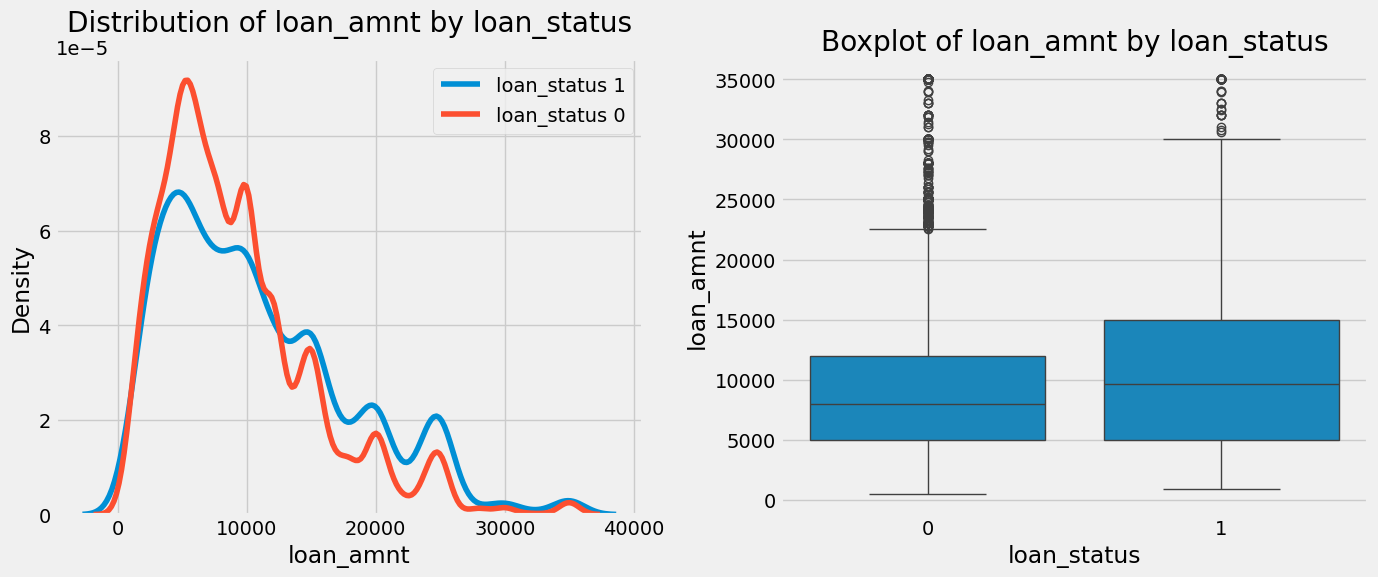

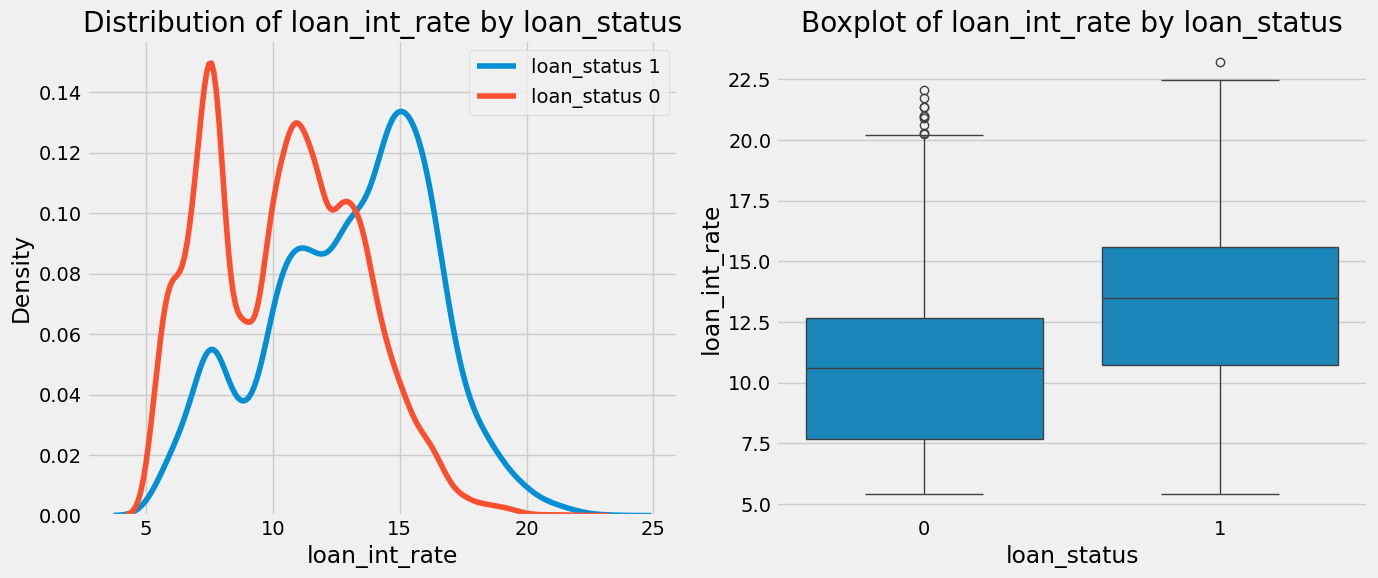

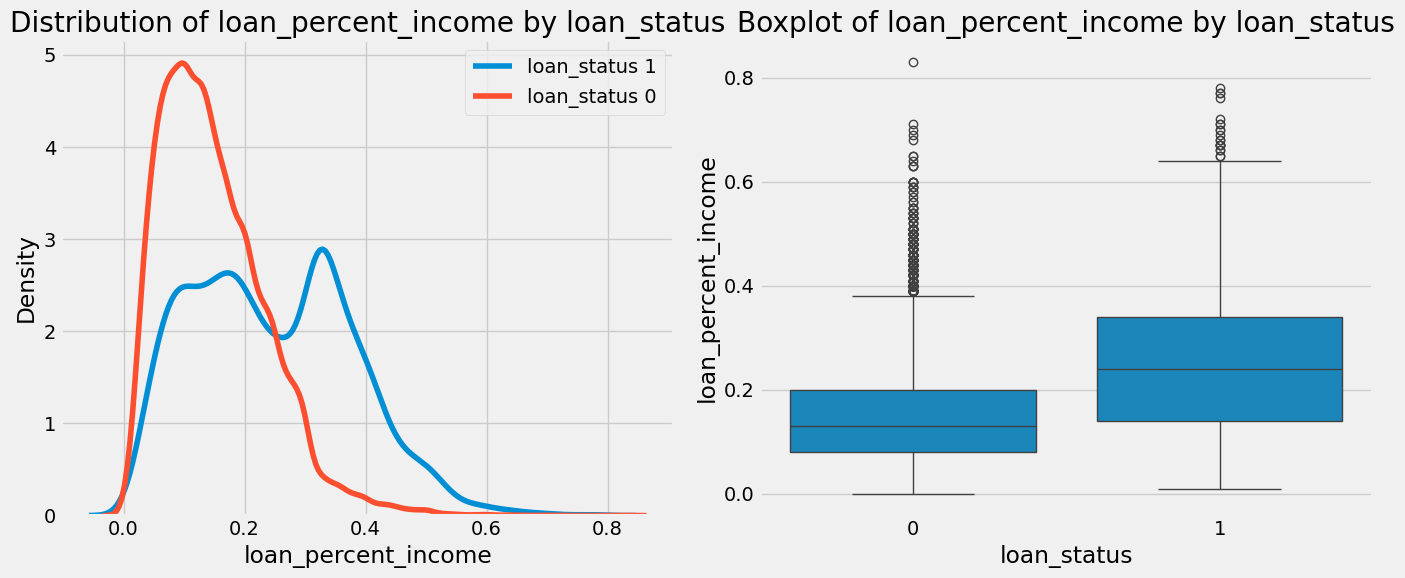

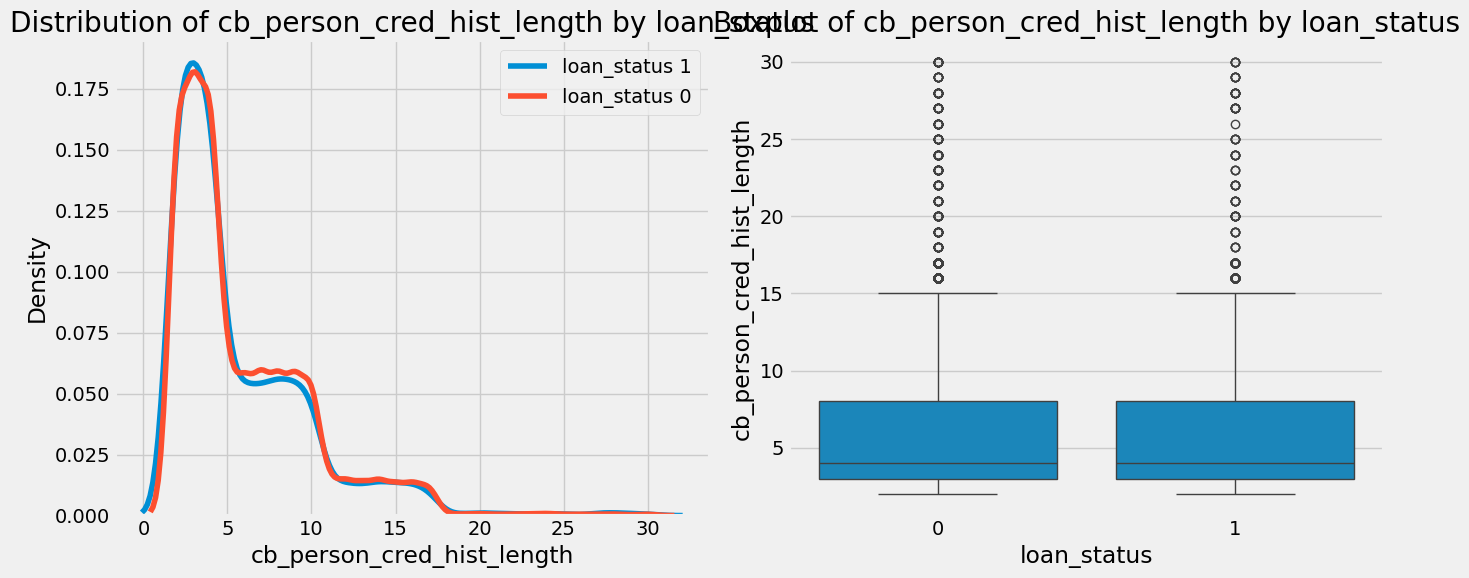

In [11]:
numerical_columns = df.select_dtypes("number").columns  # Get the numerical columns

for numerical_column in numerical_columns:
    if numerical_column != "loan_status":
        plot_dist_numerical_by_target(df, numerical_column, "loan_status")

2 features that shows higher chance loan status disapproval: `loan percent income` is high and `loan interest rate` are both high

### Categorical vs Target

In [12]:
def plot_count_categorical_by_target(df: pd.DataFrame, categorical_column: str, target_column: str) -> None:
    """
    Show count of values inside categorical column, grouped by a target column.
    
    Parameters
    ------------
        df (pd.DataFrame): The dataframe containing the data.
        categorical_column (str): The categorical column to be plotted.
        target_column (str): The target column for grouping.
    Returns
    ------------
        None
    """
    fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure

    # Bar plot with hue
    sns.countplot(data=df, x=categorical_column, hue=target_column, ax=ax, edgecolor='black')
    ax.set_title(f"Count of {categorical_column} by target_column")
    ax.set_xlabel(categorical_column)
    ax.set_ylabel("Count")

    # Rotate x labels
    plt.xticks(rotation=45)

    # Show plot
    plt.tight_layout()
    plt.show()


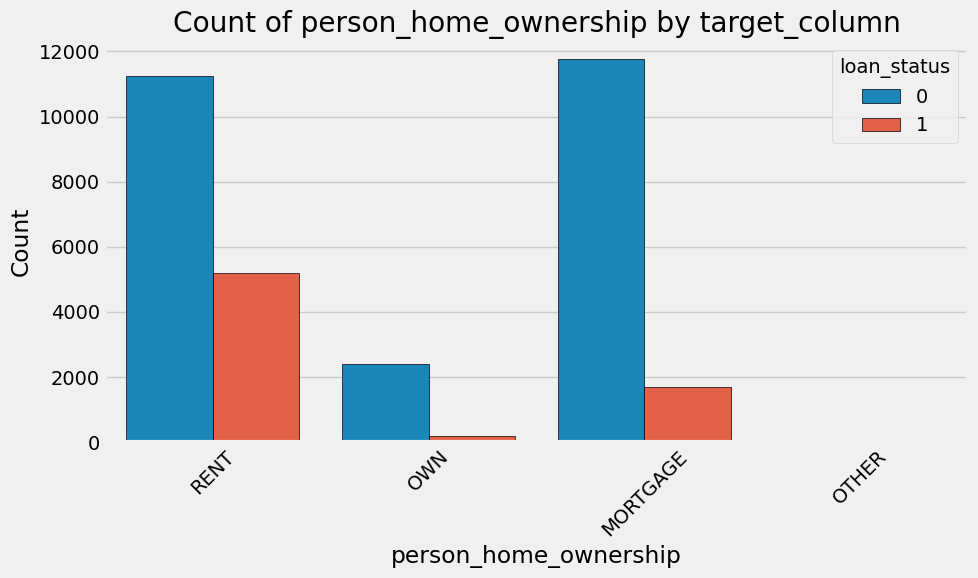

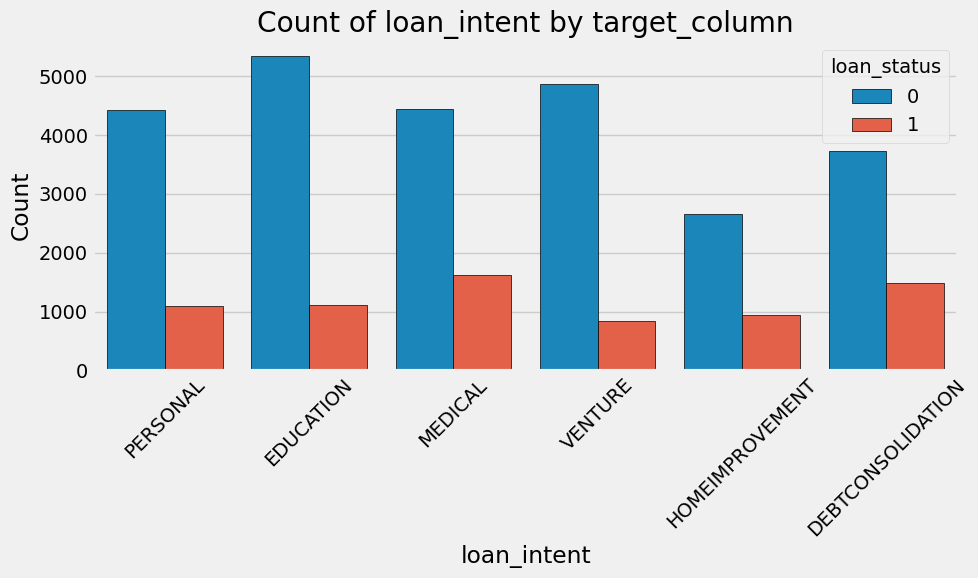

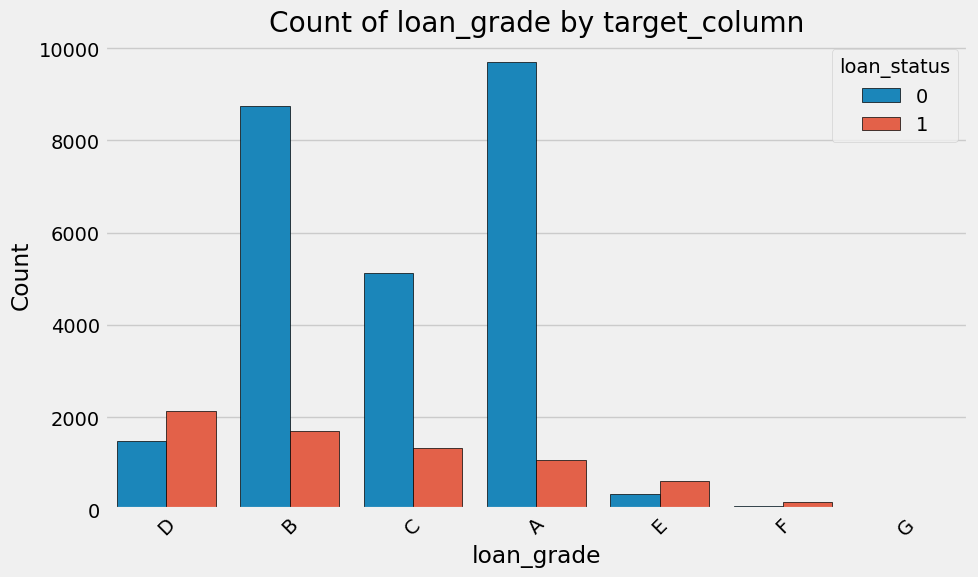

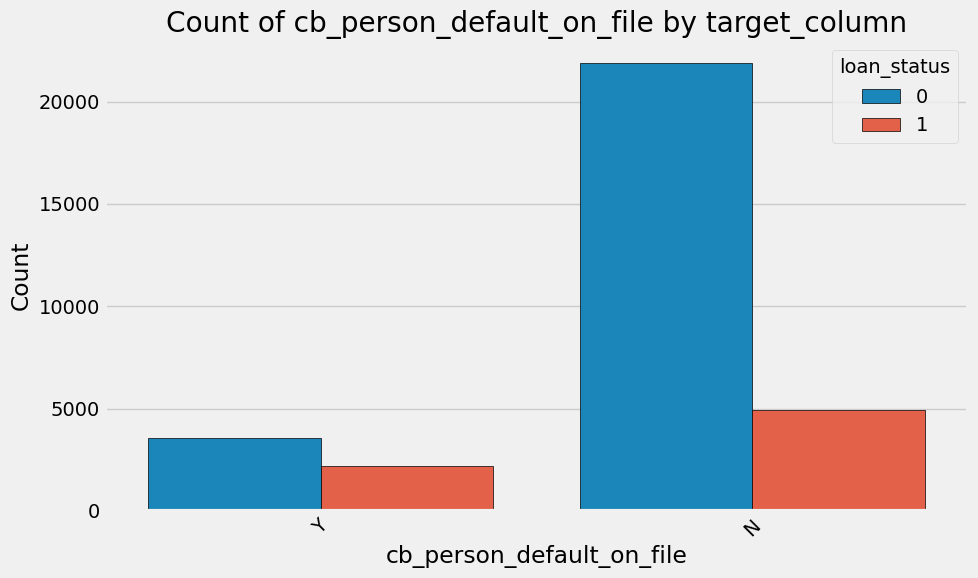

In [13]:
# Assuming df is your DataFrame and "loan_status" is the target variable
plt.style.use('fivethirtyeight')

categorical_columns = df.select_dtypes("object").columns
for categorical_column in categorical_columns:
    plot_count_categorical_by_target(df, categorical_column, "loan_status")

In [14]:
# Probability of default/ not default given values of `cb_person_default_on_file`
prob_result = df.groupby("cb_person_default_on_file")['loan_status'].value_counts(normalize=True).unstack(fill_value=0)

# Display the result
prob_result

loan_status                       0         1
cb_person_default_on_file                    
N                          0.816068  0.183932
Y                          0.621932  0.378068

Those who has history of default in the past has 37% probability of default.

In [15]:
# Probability of default/ not default given values of `person_home_ownership`
prob_result = df.groupby('person_home_ownership')['loan_status'].value_counts().unstack(fill_value=0) / len(df)

# Display the result
prob_result

loan_status                   0         1
person_home_ownership                    
MORTGAGE               0.360762  0.051871
OTHER                  0.002271  0.001013
OWN                    0.073386  0.005924
RENT                   0.345416  0.159357

2. Those who still **rent** has 16% probability of default.


In [16]:
# Probability of default/ not default given values of `loan_grade`
prob_result = df.groupby('loan_grade')['loan_status'].value_counts().unstack(fill_value=0) / len(df)

# Display the result
prob_result

loan_status         0         1
loan_grade                     
A            0.297842  0.032933
B            0.268561  0.052208
C            0.157116  0.041098
D            0.045579  0.065713
E            0.010528  0.019060
F            0.002179  0.005218
G            0.000031  0.001934

## Multicollinearity

In [17]:
def plot_heatmap(df: pd.DataFrame, figsize: Tuple[int, int]) -> None:
    """
    Show the visualization of coefficient correlation amongst features.
    
    Parameters
    ------------
        df (pd.DataFrame): The dataframe containing the data.
        figsize (Tuple[int, int]): size of the plot.
    Returns
    ------------
        None
    """
    _, ax = plt.subplots(figsize=figsize)  # Create a figure

    # Calculate the coefficient correlation
    corr = df.select_dtypes(include='number').corr()

    # Plot the heatmap
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
    ax.set_title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.show()

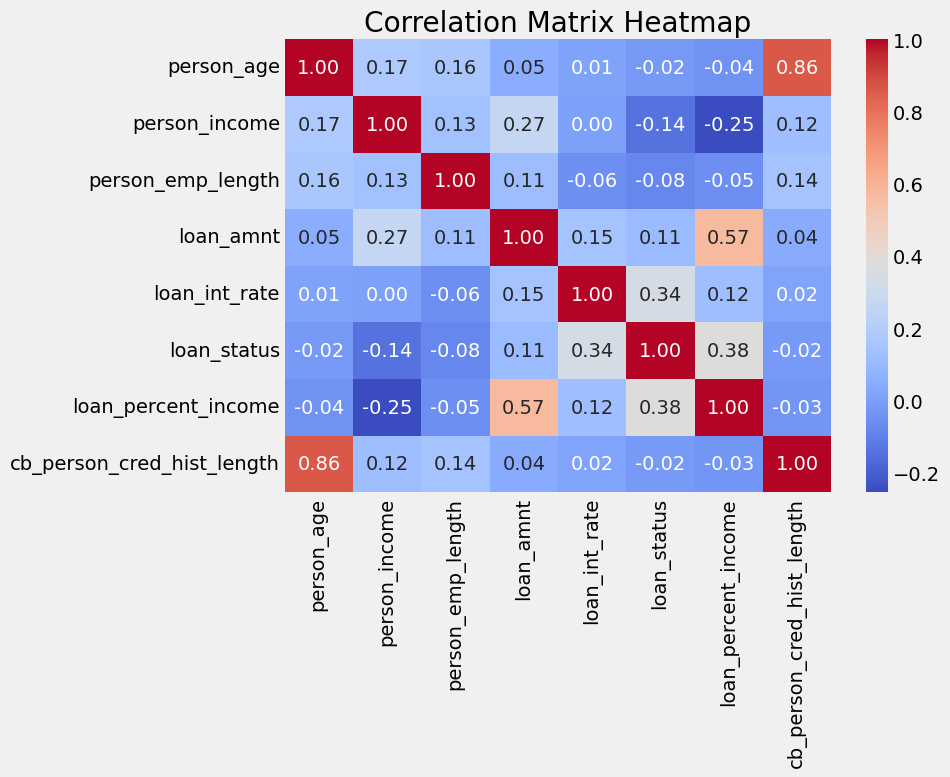

In [18]:
plot_heatmap(df, (10, 8))

In [19]:
def plot_scatter(df: pd.DataFrame, x: str, y: str, figsize: Tuple[int, int]) -> None:
    """
    Show scatter plot between two numerical columns.
    
    Parameters
    ------------
        df (pd.DataFrame): The dataframe containing the data.
        x (str): numerical column for the x-axis.
        y (str): numerical column for the y-axis.
        figsize (Tuple[int, int]): size of the plot.
    Returns
    ------------
        None
    """
    _, ax = plt.subplots(figsize=figsize)  # Create a figure
    
    # Create scatterplot with customized aesthetics
    sns.scatterplot(x=x, y=y, data=df, color='skyblue', ax=ax)

    # Add trend line
    sns.regplot(x=x, y=y, data=df, scatter=False, color='orange', ci=None, ax=ax)

    # Add labels and title
    ax.set_title(f"{x} vs {y}")
    ax.set_xlabel(x)
    ax.set_ylabel(y)

    # Show plot
    plt.show()

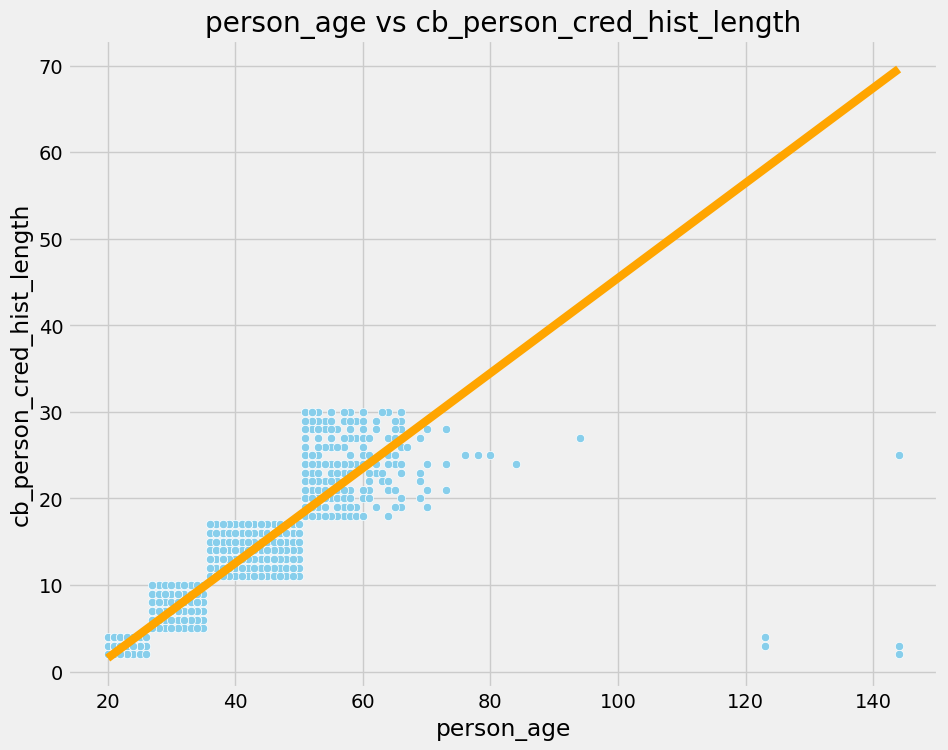

In [20]:
plot_scatter(df, "person_age", "cb_person_cred_hist_length", (10, 8))

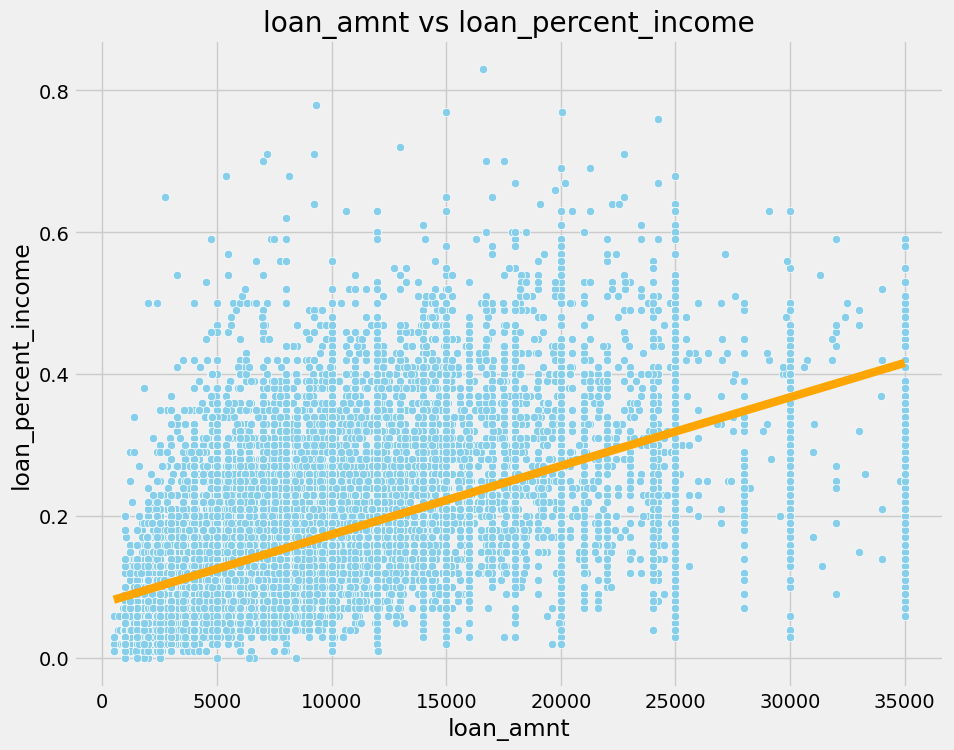

In [21]:
plot_scatter(df, "loan_amnt", "loan_percent_income", (10, 8))

# Data Preparation
For this data preparation involves:
1. Calculating the **Weight of Evidence (WOE)** and **Information Value (IV)**
2. Filter features based on the **IV**
3. Map feature values into WOE values. 

Class:
1. WOETransformer
    - Calculate WOE
    - Create mapping
2. IVTransformer
    - Transformer WOE to IV
    - Interpret the IV value
    - Filter IV
3. DataPreprocessor 
    - Split Data
    - Create binning
4. Visualizer:
    - plot data (show/ save)
5. Model
    - Train
    - Predict
    - Evaluate
6. ScoreTransformer:
    - Calculate score using WOE
    - Transform to WOE

## Data Splitting

In [10]:
# Imports
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from scipy import stats
from typing import Tuple
from typing import Union
from sklearn.model_selection import train_test_split
class DataPreprocessor:
    def __init__(self):
        pass

    @staticmethod
    def split_data(df: pd.DataFrame, label: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Split data into train and test data evenly based on their label values.

        Args:
            df (pd.DataFrame): Pandas DataFrame containing the data.
            label (str): Label column.
        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: Train and test Pandas DataFrame.
        """
        X, y = df.drop(columns=[label]), df[label]
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, shuffle=True, random_state=42)
        train = pd.concat([X_train, y_train], axis=1)
        test = pd.concat([X_test, y_test], axis=1)

        return train, test
    
    @staticmethod
    def generate_bins(df: pd.DataFrame, numerical_columns: str, label_column:str, num_of_bins: int) -> pd.DataFrame:
        """
        Create bins for a numerical column, dividing it into a specified number of equal-sized bins.

        Args:
            df (pd.DataFrame): Pandas DataFrame containing the data.
            numerical_column (str): Numerical column.
            num_of_bins (int): Number of bins to create.
        Returns:
            pd.DataFrame: Pandas DataFrame with `numerical_column` values are changed to bin.
        """
        for numerical_column in numerical_columns:
            if numerical_column != label_column:
                df[numerical_column] = pd.qcut(
                    df[numerical_column], 
                    q = num_of_bins, 
                    duplicates="drop"
                )
        return df
        
    @staticmethod
    def fill_missing_categorical(df: pd.DataFrame) -> pd.DataFrame:
        """
        Fill missing categorical columns inside Pandas DataFrame with `Missing`.

        Args:
            df (pd.DataFrame): Pandas DataFrame containing the data.
        Returns:
            pd.DataFrame: Pandas DataFrame with `numerical_column` values are changed to bin.
        """
        for column in df.columns:
            if df[column].isna().sum() > 0 and df[column].dtype in ["object", "category"]:
                # Add category 'Missing' to replace the missing values
                df[column] = df[column].cat.add_categories('Missing')
                # Replace missing values with category 'Missing'
                df[column] = df[column].fillna(value = 'Missing')
        return df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# split data betweem train and text
train, test = DataPreprocessor.split_data(df, "loan_status")

## Weight of Evidence (WOE) and Information Value (IV)
For this data preparation involves:
1. Calculating the **WOE** and **IV**
2. Filter features based on the **IV**
3. Map feature values into **WOE** values. 

### 1. Perform Binning on Numerical Variables

In [91]:
from optbinning import OptimalBinning

numerical_columns = train.select_dtypes("number")
categorical_columns = train.select_dtypes("object")

numerical_optb_obj = {}
categorical_optb_obj = {}

for numerical_column in numerical_columns:
    if numerical_column != "loan_status":
        optb = OptimalBinning(name=numerical_column, dtype="numerical", solver="cp")
        X = train[numerical_column].values
        y = train["loan_status"]
        optb.fit(X, y)
        numerical_optb_obj[numerical_column] = optb

for categorical_column in categorical_columns:
    optb = OptimalBinning(name=categorical_column, dtype="categorical", solver="cp")
    X = train[categorical_column].values
    y = train["loan_status"]
    optb.fit(X, y)
    categorical_optb_obj[categorical_column] = optb

# Combine into 1 dictionary
optb_objs = numerical_optb_obj | categorical_optb_obj

gc.enable()
numerical_columns = None
categorical_columns = None
numerical_optb_obj = None
categorical_optb_obj = None
gc.collect()

116783

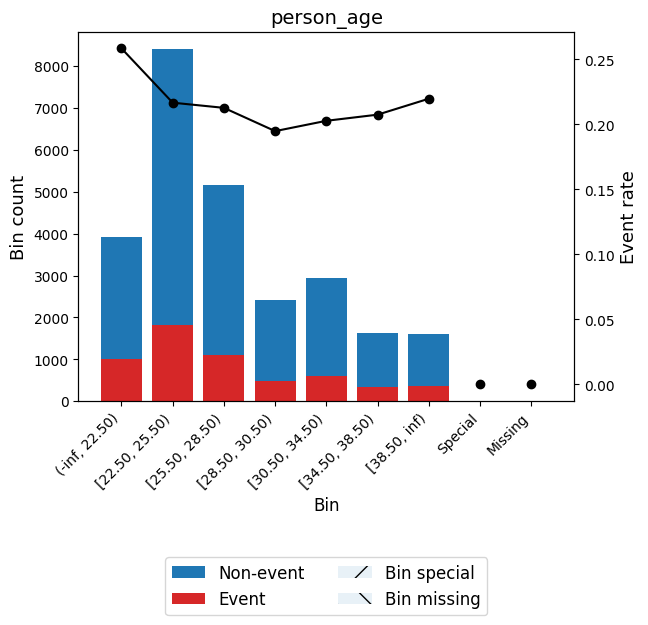

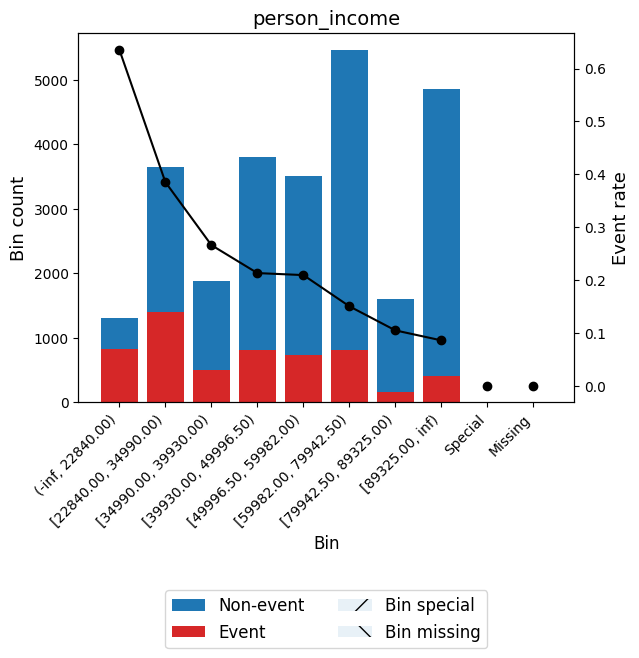

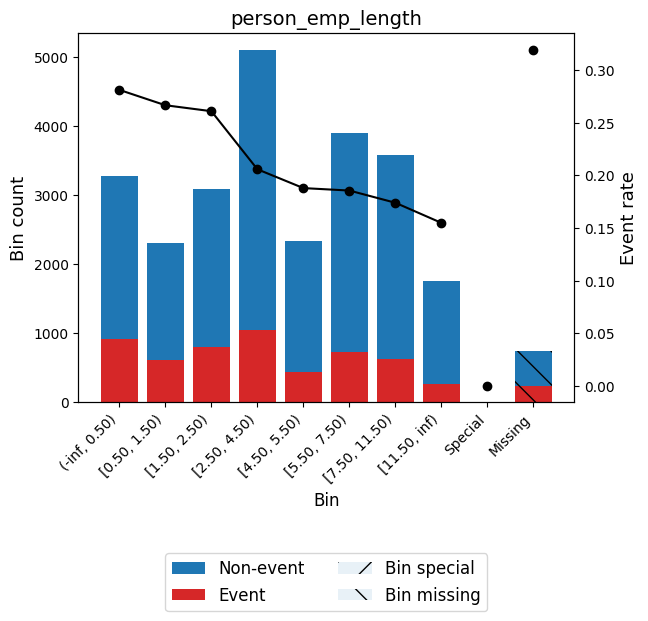

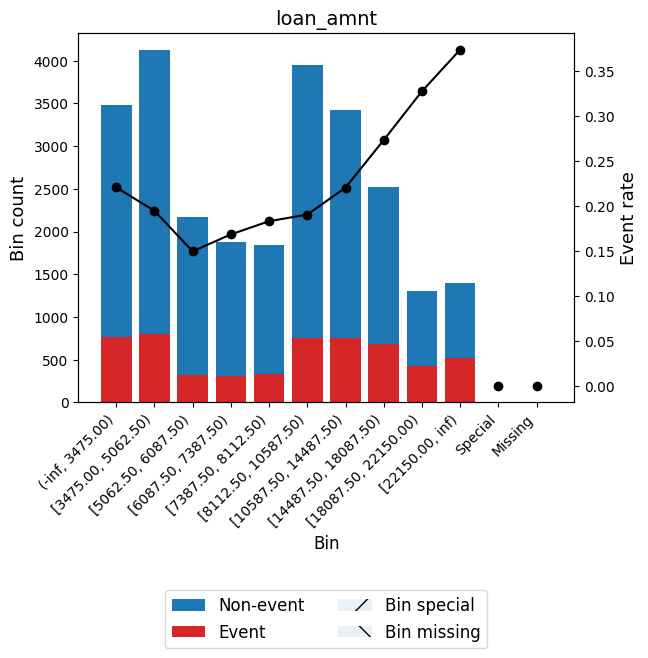

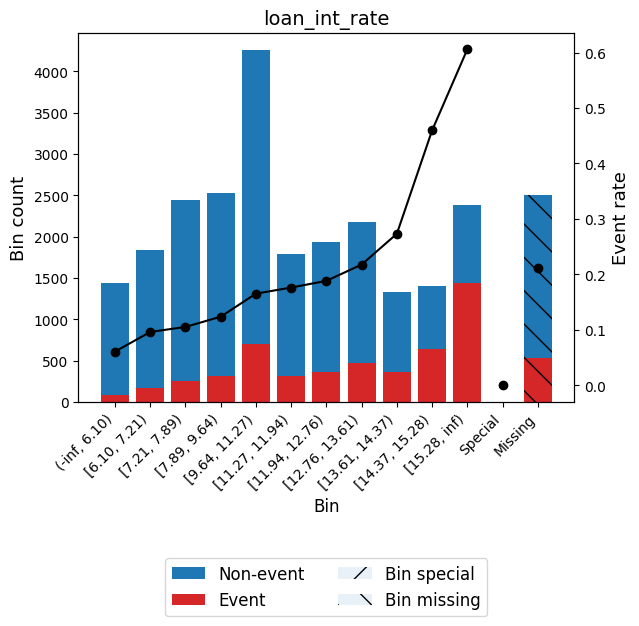

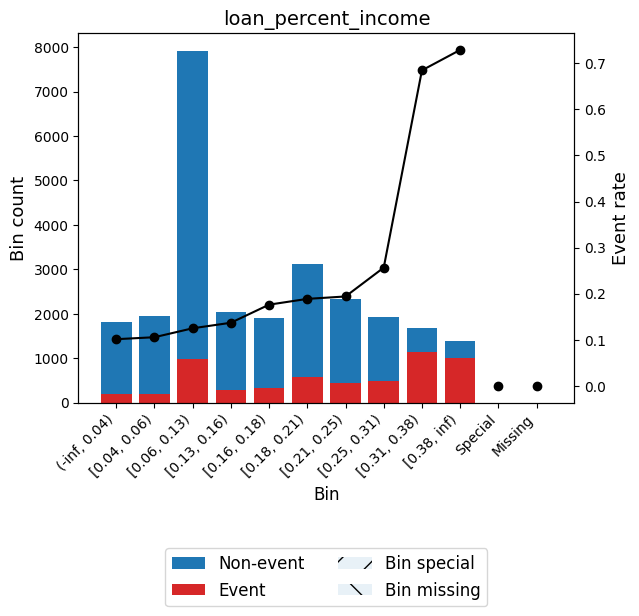

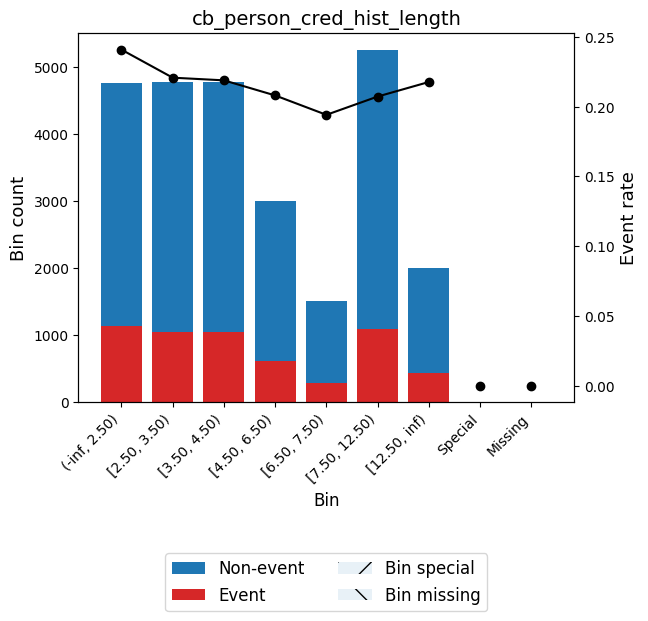

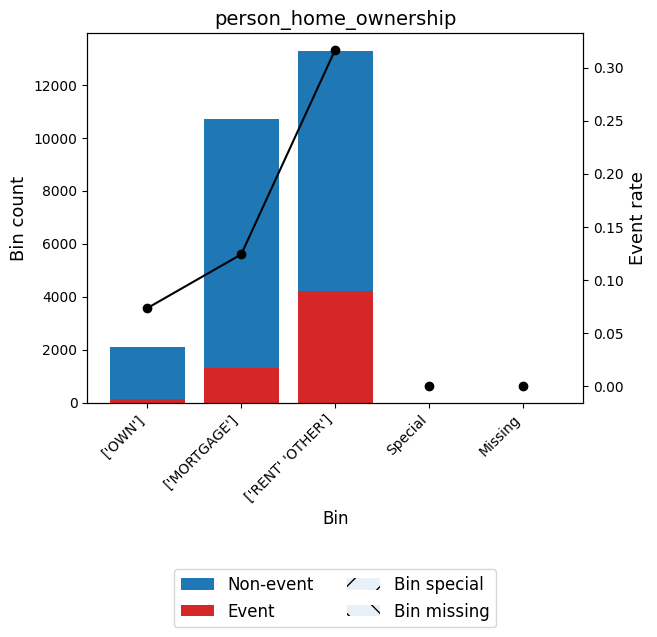

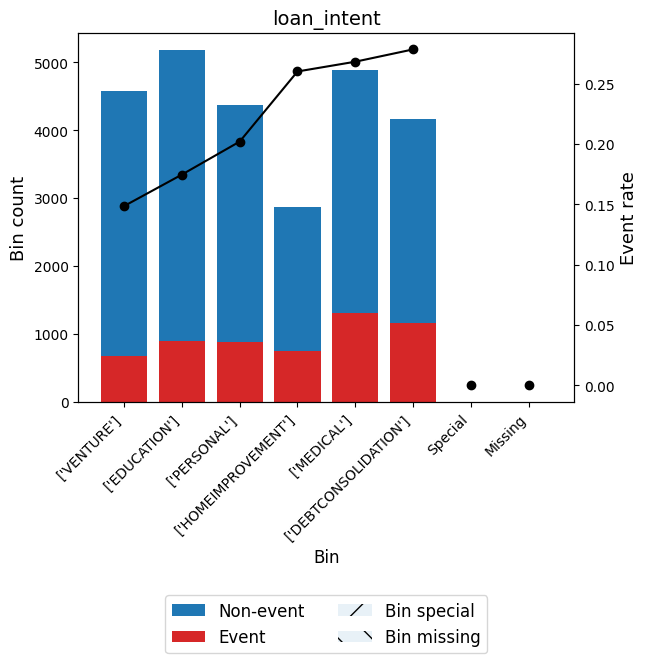

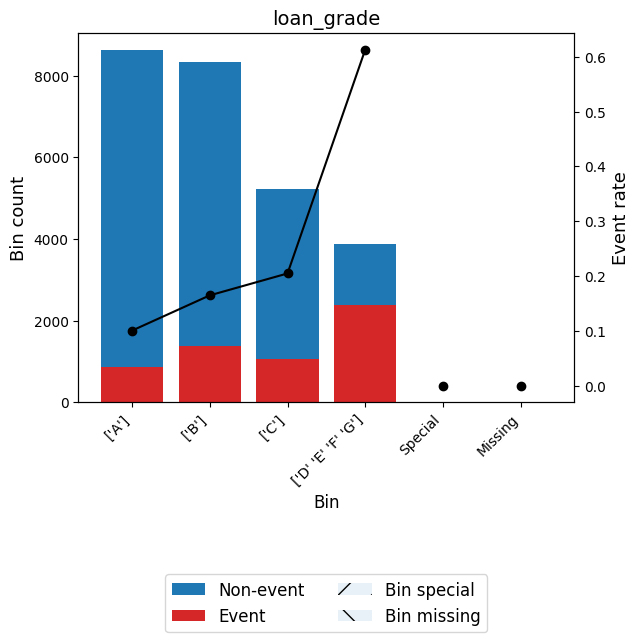

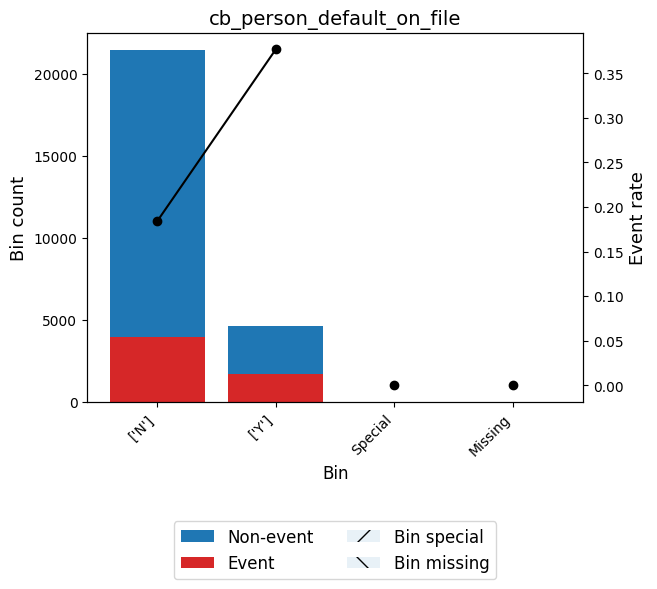

In [92]:
for _, optb in optb_objs.items():
    binning_table = optb.binning_table
    binning_table.build()
    binning_table.plot(metric="event_rate", show_bin_labels=True)

1. Those who are still producing low income has a high probability of default.
2. Those who are still new in the job has a high probability of default.
3. High interest rate (`loan_int_rate`) has a high probability of default.
4. Hihg proportion of loan with respect to income (`loan_percent_income`) has a high probability of default. 

### 2. Calculate WoE and IV
WOE and IV is already automatically calculated using the build() method

In [93]:
characteristics = []
ivs = []
for column, optb in optb_objs.items():
    binning_table = optb.binning_table
    characteristics.append(column)
    ivs.append(binning_table.build().loc["Totals", "IV"])

IV_df = pd.DataFrame({
    "Characteristic": characteristics,
    "IV": ivs
})

In [94]:
# 3. Filter those with low value of IV
def interpret_iv(value):
    if value < 0.02:
        return "Not Predictive"
    elif 0.02 <= value and value < 0.1:
        return "Weak Predictive"
    elif 0.1 <= value and value < 0.3:
        return "Medium Predictive"
    elif 0.3 <= value and value < 0.5:
        return "Strong Predictive"
    else:
        return "Very Strong Predictive"

IV_df["Interpretation"] = IV_df["IV"].apply(lambda x: interpret_iv(x))
IV_df = IV_df.sort_values(by="IV", ascending=False)
IV_df

Characteristic        IV          Interpretation
5          loan_percent_income  0.952405  Very Strong Predictive
9                   loan_grade  0.845847  Very Strong Predictive
4                loan_int_rate  0.682771  Very Strong Predictive
1                person_income  0.573963  Very Strong Predictive
7        person_home_ownership  0.389704       Strong Predictive
10   cb_person_default_on_file  0.162480       Medium Predictive
3                    loan_amnt  0.097241         Weak Predictive
8                  loan_intent  0.088686         Weak Predictive
2            person_emp_length  0.068640         Weak Predictive
0                   person_age  0.011128          Not Predictive
6   cb_person_cred_hist_length  0.005621          Not Predictive

Exclude Characteristic with is interpret as `Not Predictive`

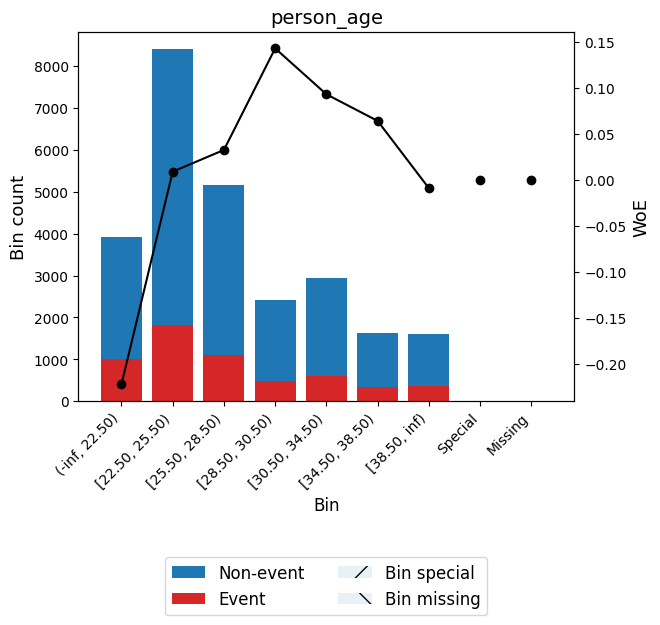

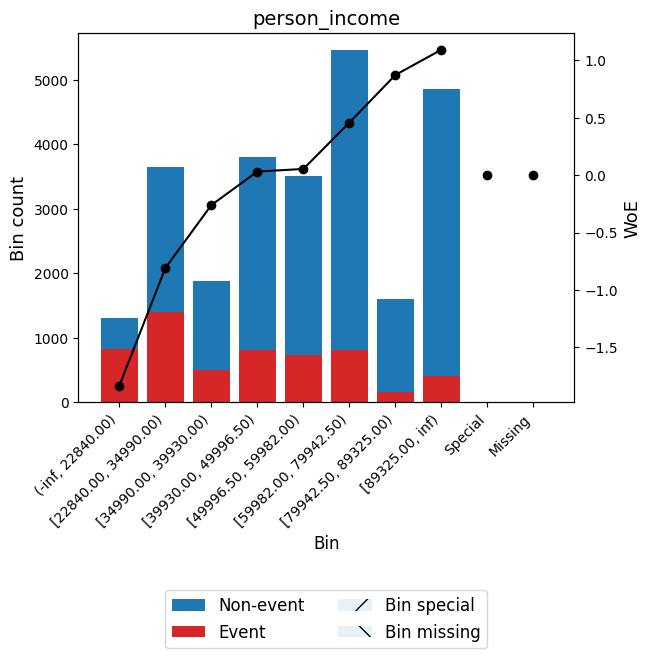

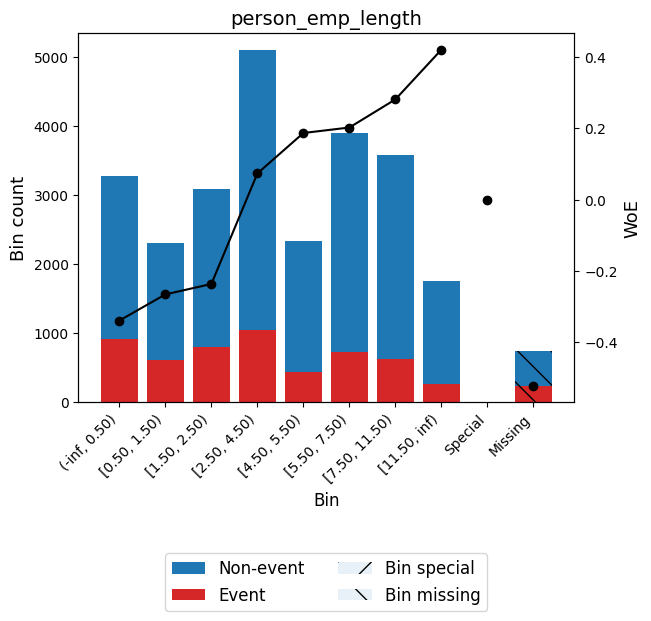

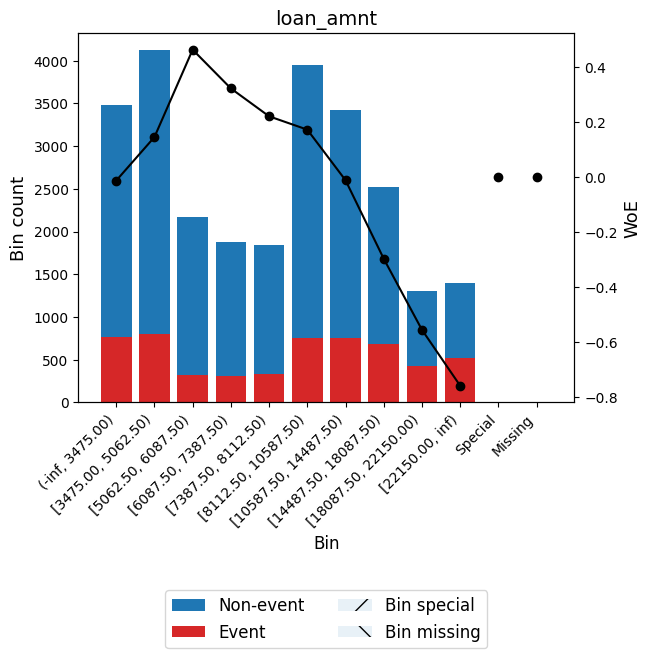

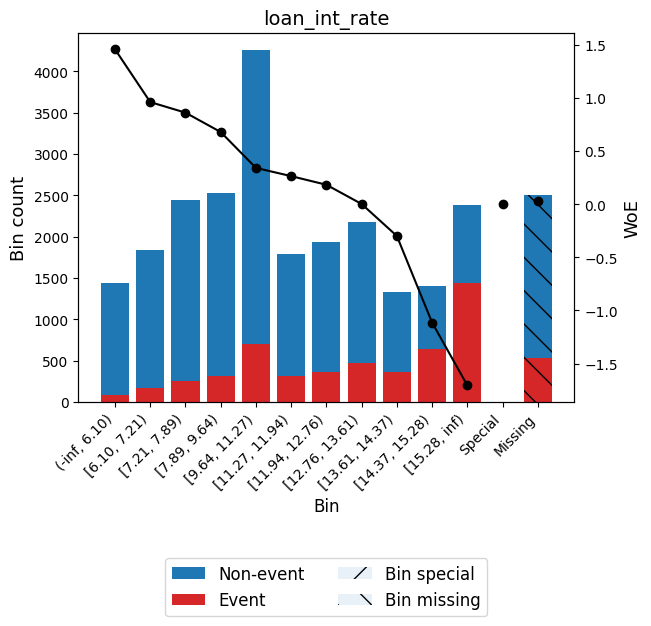

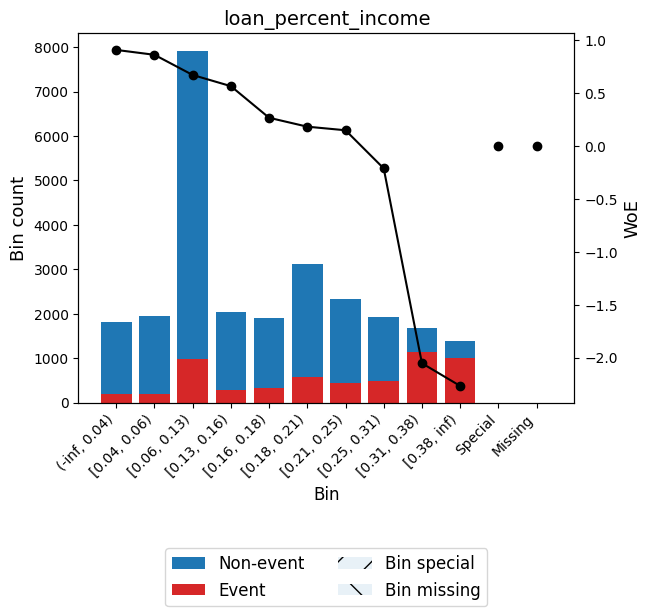

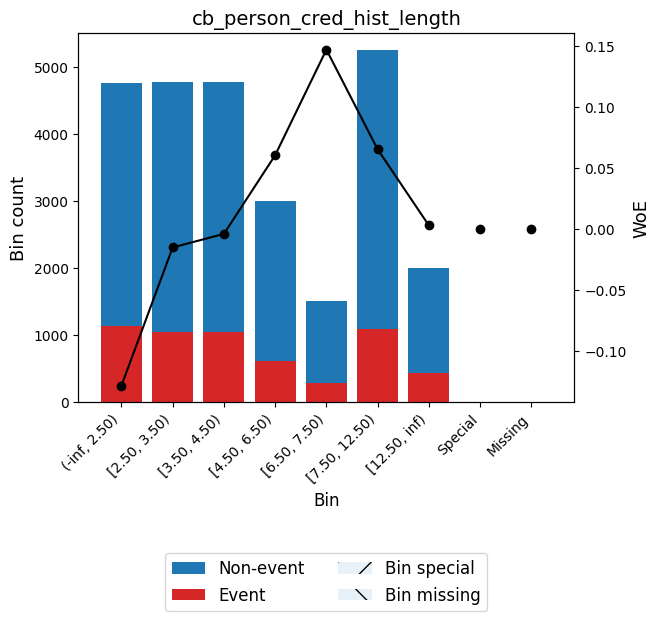

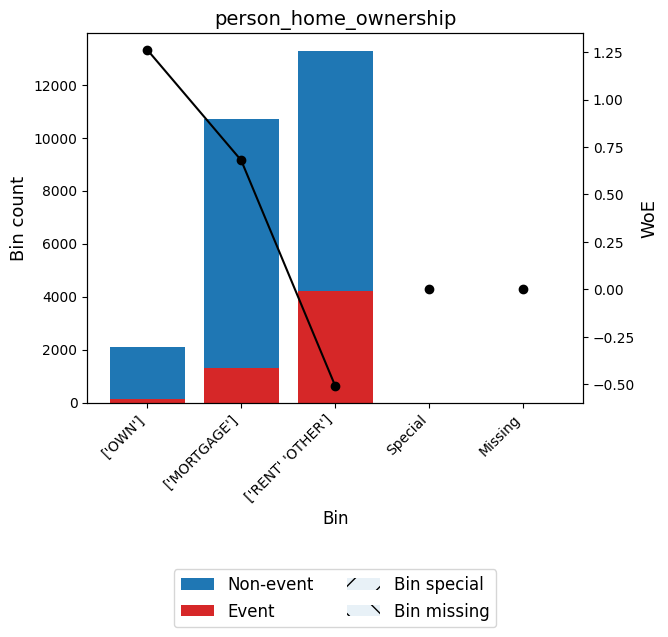

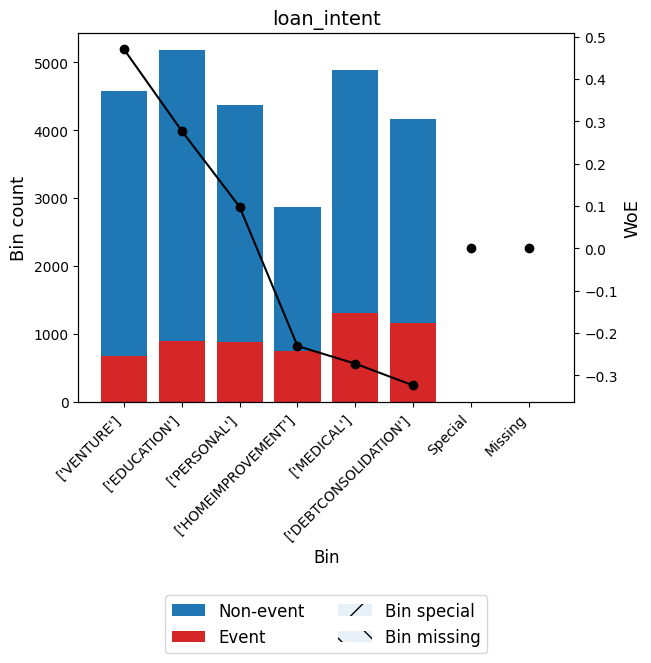

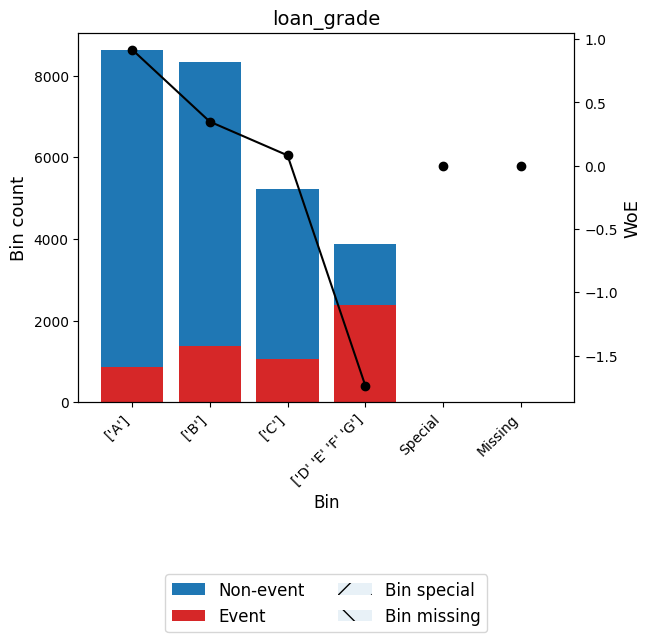

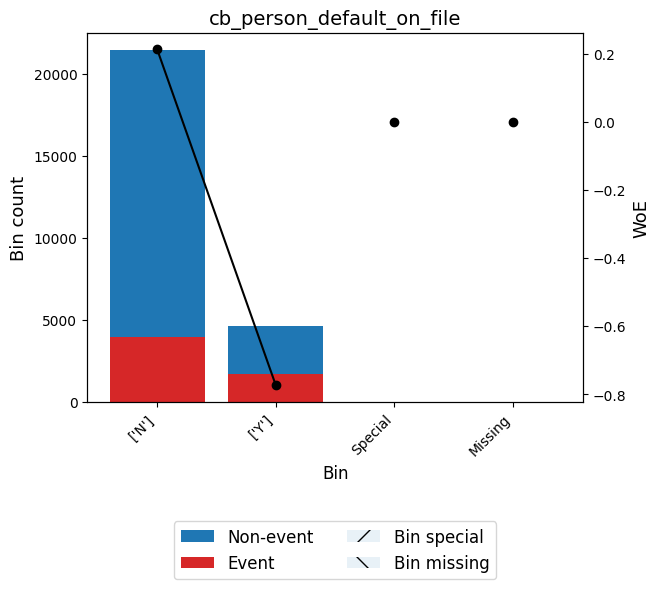

In [95]:
for _, optb in optb_objs.items():
    binning_table = optb.binning_table
    binning_table.build()
    binning_table.plot(metric="woe", show_bin_labels=True)

### 3. Map Column Values with Weight of Evidence (WOE) Values

In [43]:
# Map column values into Weight of Evidence values for Training Data
train_woe = train.copy()
test_woe = test.copy()

train_woe = woe_transformer.transform(train_woe, "loan_status")
test_woe = woe_transformer.transform(test_woe, "loan_status")

In [97]:
train_woe = train.copy()
test_woe = test.copy()


for column in train.columns:
    if column != "loan_status":
        X = train_woe[column].values
        train_woe[column] = optb_objs[column].transform(X, metric="woe")

for column in test.columns:
    if column != "loan_status":
        X = test_woe[column].values
        test_woe[column] = optb_objs[column].transform(X, metric="woe")

# Feature Selection

1. Prepare all features
2. Loop all features start from 1 and adding it up and calculate the cross validation score
3. Document it

In [100]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.base import BaseEstimator


class FeatureSelector:
    def __init__(self):
        pass
    
    def forward_feature_selection(
        self,
        X_train: pd.DataFrame, 
        y_train: Union[np.array, list], 
        scoring='roc_auc', 
        cv=5
    ) -> Tuple[np.array, pd.DataFrame]:
    
        predictors_list = []
        score_list = []
        predictors = []

        for column in X_train.columns:
            predictors = predictors + [column]

            X = X_train.loc[:, predictors]
            y = y_train

            # Create model
            model = LogisticRegression(random_state=42)
            
            # Perform cross-validation and get the average score
            scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
            
            # Document the predictors and average score
            predictors_list.append(predictors)
            score_list.append(np.mean(scores))

        ffs_df = pd.DataFrame({
            "Predictors": predictors_list,
            "Score": score_list
        })
        best_model = ffs_df.iloc[ffs_df["Score"].argmax()]
        selected_features = best_model["Predictors"]

        return selected_features, ffs_df

In [103]:
feature_selector = FeatureSelector()
X_train, y_train = train_woe.drop(columns=["loan_status"]), train_woe["loan_status"]
selected_features, ffs_df = feature_selector.forward_feature_selection(
    X_train=X_train, 
    y_train=y_train, 
    scoring='roc_auc', 
    cv=5
)
display(selected_features)
display(ffs_df)

['person_age',
 'person_income',
 'person_home_ownership',
 'person_emp_length',
 'loan_intent',
 'loan_grade',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_default_on_file',
 'cb_person_cred_hist_length']

Predictors     Score
0                                        [person_age]  0.526125
1                         [person_age, person_income]  0.696999
2   [person_age, person_income, person_home_owners...  0.740019
3   [person_age, person_income, person_home_owners...  0.740820
4   [person_age, person_income, person_home_owners...  0.754527
5   [person_age, person_income, person_home_owners...  0.843933
6   [person_age, person_income, person_home_owners...  0.866484
7   [person_age, person_income, person_home_owners...  0.866504
8   [person_age, person_income, person_home_owners...  0.886692
9   [person_age, person_income, person_home_owners...  0.886651
10  [person_age, person_income, person_home_owners...  0.886708

# Modelling

In [104]:
from sklearn.linear_model import LogisticRegression

class LogisticRegressionModel:
    def __init__(self, *args, **kwargs):
        """
        Initialize Logistic Regression with specified parameters.

        Args:
            penalty (str, optional): Specifies the norm used in the penalization. Defaults to 'l2'.
            C (float, optional): Inverse of regularization strength; must be a positive float. Smaller values specify stronger regularization. Defaults to 1.0.
            solver (str, optional): Algorithm to use in the optimization problem. Defaults to 'lbfgs'.
            max_iter (int, optional): Maximum number of iterations taken for the solvers to converge. Defaults to 100.
        """
        self.model = LogisticRegression(*args, **kwargs)

    def fit(self, X, y):
        """
        Fit the Logistic Regression model to the given training data.

        Args:
            X (array-like or sparse matrix of shape (n_samples, n_features)): Training data.
            y (array-like, shape (n_samples,)): Target values.

        Returns:
            self: Returns an instance of self.
        """
        self.model.fit(X, y)

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Args:
            X (array-like or sparse matrix of shape (n_samples, n_features)): Samples.

        Returns:
            array, shape (n_samples,): Predicted class label per sample.
        """
        return self.model.predict(X)

    def predict_proba(self, X):
        """
        Probability estimates.

        The returned estimates for all classes are ordered by the label of classes.

        Args:
            X (array-like or sparse matrix of shape (n_samples, n_features)): Samples.

        Returns:
            array, shape (n_samples, n_classes): Probability of the sample for each class in the model.
        """
        return self.model.predict_proba(X)
    
    def get_coefficient(self):
        return self.model.coef_.reshape(-1)

    def get_intercept(self):
        return self.model.intercept_
    
    def evaluate(self):
        pass

In [111]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
import numpy as np

class EvaluationMetrics:
    def __init__(self, y_true, y_pred_prob):
        """
        Initialize with true labels and predicted probabilities.

        Args:
            y_true (array-like, shape (n_samples,)): True labels.
            y_pred_prob (array-like, shape (n_samples,)): Predicted probabilities for the positive class.
        """
        self.y_true = y_true
        self.y_pred_proba = y_pred_prob

    def roc_auc(self):
        """
        Calculate ROC AUC (Area Under the Receiver Operating Characteristic Curve).

        Returns:
            float: ROC AUC score.
        """
        return roc_auc_score(self.y_true, self.y_pred_proba)

    def roc_pr_auc(self):
        """
        Calculate ROC PR AUC (Area Under the Receiver Operating Characteristic - Precision Recall Curve).

        Returns:
            float: ROC PR AUC score.
        """
        return average_precision_score(self.y_true, self.y_pred_proba)

    def gini(self):
        """
        Calculate Gini coefficient.

        Returns:
            float: Gini coefficient.
        """
        fpr, tpr, _ = roc_curve(self.y_true, self.y_pred_proba)
        roc_auc = roc_auc_score(self.y_true, self.y_pred_proba)
        return 2 * roc_auc - 1

    def ks(self):
        """
        Calculate Kolmogorov-Smirnov (KS) statistic.

        Returns:
            float: KS statistic.
        """
        y_pred_proba_not_default = self.y_pred_proba[self.y_true == 0]
        y_pred_proba_default = self.y_pred_proba[self.y_true == 1]
        ks_stat, p_value = stats.ks_2samp(y_pred_proba_not_default, y_pred_proba_default)
        return ks_stat
    
    

# Example usage:
# Assuming y_true and y_pred_prob are your true labels and predicted probabilities
# evaluation = EvaluationMetrics(y_true, y_pred_prob)
# roc_auc = evaluation.roc_auc()
# roc_pr_auc = evaluation.roc_pr_auc()
# gini = evaluation.gini()
# ks = evaluation.ks()


In [107]:
model = LogisticRegressionModel(random_state=42)
X_train, y_train = train_woe.drop(columns=["loan_status"]), train_woe["loan_status"]
model.fit(X_train[selected_features], y_train)

In [108]:
intercept = model.get_intercept()
coef = model.get_coefficient()
print("Intercept(s): ", intercept)
print("Coef:")
for feature, coef in zip(selected_features, coef):
    print(f"{feature} = {coef:.5f}")

Intercept(s):  [-1.38052402]
Coef:
person_age = 0.02263
person_income = -0.87605
person_home_ownership = -0.93116
person_emp_length = -0.28348
loan_intent = -1.48843
loan_grade = -1.17653
loan_amnt = -0.55792
loan_int_rate = -0.09737
loan_percent_income = -0.98587
cb_person_default_on_file = 0.03436
cb_person_cred_hist_length = -0.55837


In [ ]:
def plot_predict_proba(y_true: np.array, y_pred_proba: np.array) -> None:
    """
    Plot the predicted probability distributions for the default and non-default classes.
    
    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
    Return:
        None
    """

    # Create a figure and axis object
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(8, 5))

    # Plot histograms for the predicted probabilities
    sns.histplot(y_pred_proba[y_true == 0], label="Not Default", kde=True, color='blue', alpha=0.6, bins=30)
    sns.histplot(y_pred_proba[y_true == 1], label="Default", kde=True, color='red', alpha=0.6, bins=30)

    # Add title and axis labels
    plt.title('Predicted Probability Distributions for Default and Not Default', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Probability', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Add legend
    plt.legend(title='Label', fontsize=12, title_fontsize='13')

    # Show grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Display the plot
    plt.show()

def plot_roc_auc_curve(y_true: np.array, y_pred_proba: np.array) -> None:
    """
    Plot the ROC curve and calculate the AUC.
    
    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
    Return:
        None
    """
    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line

    # Title and labels
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)

    # Add legend
    plt.legend(loc="lower right", fontsize=12)

    # Show grid for better readability
    plt.grid(axis='both', linestyle='--', alpha=0.7)

    # Display the plot
    plt.show()

def plot_precision_recall_curve(y_true: np.array, y_pred_proba: np.array) -> None:
    """
    Plot the Precision-Recall curve and calculate the Average Precision (AP).
    
    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
    Return:
        None
    """
    # Compute Precision-Recall curve and average precision score
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    average_precision = average_precision_score(y_true, y_pred_proba)

    # Plotting the Precision-Recall curve
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(8, 5))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.2f})')

    # Title and labels
    plt.title('Precision-Recall Curve', fontsize=16, fontweight='bold')
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)

    # Add legend
    plt.legend(loc="lower left", fontsize=12)

    # Show grid for better readability
    plt.grid(axis='both', linestyle='--', alpha=0.7)

    # Display the plot
    plt.show()

def plot_ks(y_true: np.array, y_pred_proba: np.array) -> None:
    """
    Plot the Kolmogorov-Smirnov (KS) statistic.
    
    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
    Return:
        None
    """
    # Generate two sample distributions
    y_pred_proba_not_default = y_pred_proba[y_true == 0]
    y_pred_proba_default = y_pred_proba[y_true == 1]

    # Calculate the KS statistic
    ks_stat, p_value = stats.ks_2samp(y_pred_proba_not_default, y_pred_proba_default)

    # Plot the CDFs
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(8, 5))
    plt.hist(y_pred_proba_not_default, bins=50, density=True, histtype='step', cumulative=True, label='Not Default', linewidth=2)
    plt.hist(y_pred_proba_default, bins=50, density=True, histtype='step', cumulative=True, label='Default', linewidth=2)
    plt.axvline(ks_stat, linestyle="--", linewidth=2, color="black")
    plt.title('KS Plot')
    plt.xlabel('Value')
    plt.ylabel('Cumulative Probability')
    plt.legend(title=f'KS Statistic: {ks_stat:.3f}, P-value: {p_value:.3f}')
    plt.show()


def plot_calibration_curve(y_true: np.array, y_pred_proba: np.array, model_name: str, n_bins=10) -> None:
    # Compute calibration curve
    prob_true, prob_pred = calibration_curve(y_true, y_pred_proba, n_bins=n_bins)
    
    # Plot calibration curve
    plt.figure(figsize=(10, 10))
    plt.plot(prob_pred, prob_true, marker='o', label=model_name)
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration plot')
    plt.legend()
    plt.grid(True)
    plt.show()


SyntaxError: invalid syntax (1381710854.py, line 131)

In [112]:
y_pred_proba = model.predict_proba(X_train[selected_features])[:, -1]
evaluation = EvaluationMetrics(y_train, y_pred_proba)
roc_auc = evaluation.roc_auc()
roc_pr_auc = evaluation.roc_pr_auc()
gini = evaluation.gini()
ks = evaluation.ks()

print(f"AUC: {roc_auc}")
print(f"AUCPR: {roc_pr_auc}")
print(f"Gini: {gini}")
print(f"KS: {ks}")

AUC: 0.8869611096667636
AUCPR: 0.770171684239646
Gini: 0.7739222193335271
KS: 0.6408402991411668


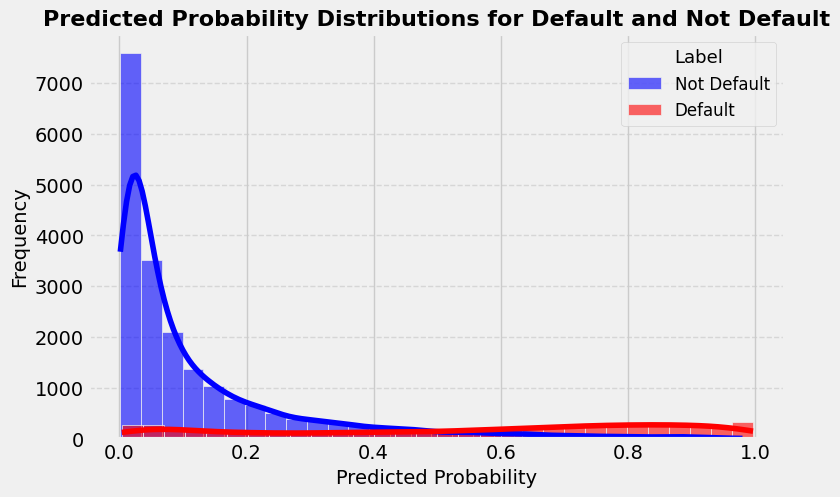

In [113]:
y_pred_proba = model.predict_proba(X_train[selected_features])[:, -1]
plot_predict_proba(y_train, y_pred_proba)

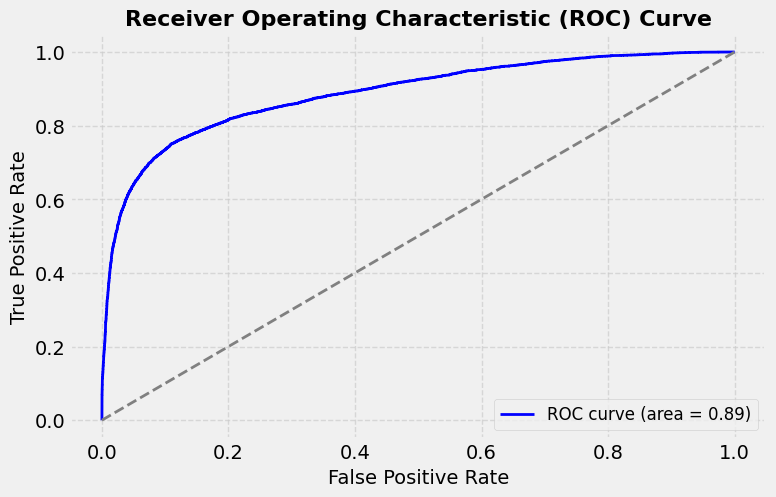

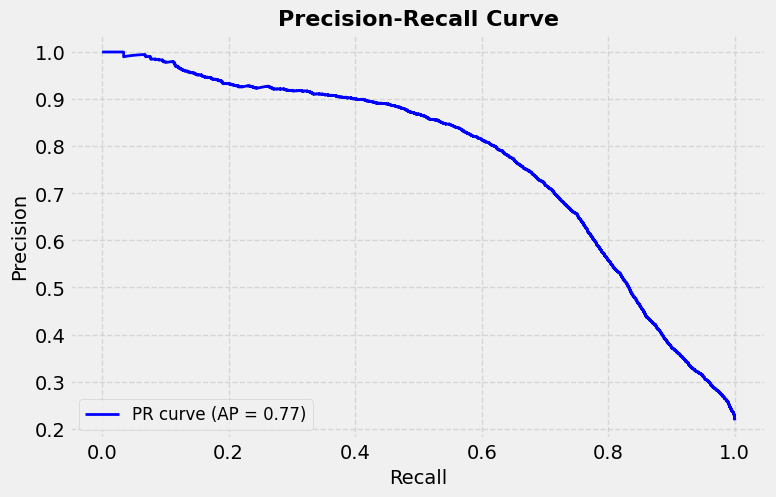

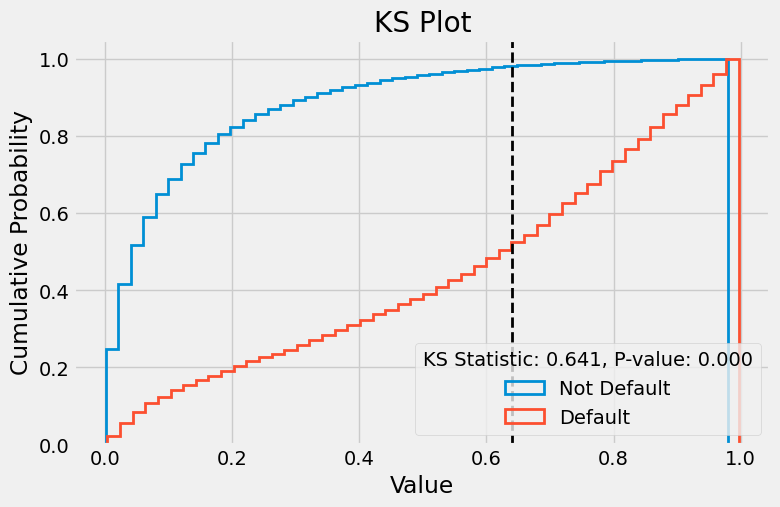

InvalidParameterError: The 'n_bins' parameter of calibration_curve must be an int in the range [1, inf). Got 'Logistic Regression' instead.

In [119]:
y_pred_proba = model.predict_proba(X_train[selected_features])[:, -1]
plot_roc_auc_curve(y_train, y_pred_proba)
plot_precision_recall_curve(y_train, y_pred_proba)
plot_ks(y_train, y_pred_proba)
plot_calibration_curve(y_train, y_pred_proba, "Logistic Regression")

# Evaluate on Testing Data

In [ ]:
X_test, y_test = test_woe.drop(columns=["loan_status"]), test_woe["loan_status"]
y_pred_proba = model.predict_proba(X_test[selected_features])[:, -1]
evaluation = EvaluationMetrics(y_test, y_pred_proba)
roc_auc = evaluation.roc_auc()
roc_pr_auc = evaluation.roc_pr_auc()
gini = evaluation.gini()
ks = evaluation.ks()

print(f"AUC: {roc_auc}")
print(f"AUCPR: {roc_pr_auc}")
print(f"Gini: {gini}")
print(f"KS: {ks}")

AUC: 0.8629268235453251
AUCPR: 0.6975414108837127
Gini: 0.7258536470906503
KS: 0.5971426165858533


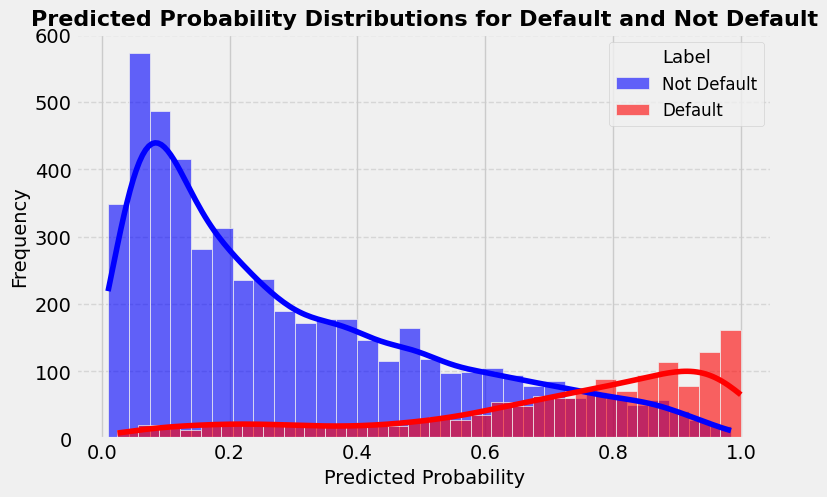

In [ ]:
X_test, y_test = test_woe.drop(columns=["loan_status"]), test_woe["loan_status"]
y_pred_proba = model.predict_proba(X_test[selected_features])[:, -1]
plot_predict_proba(y_test, y_pred_proba)

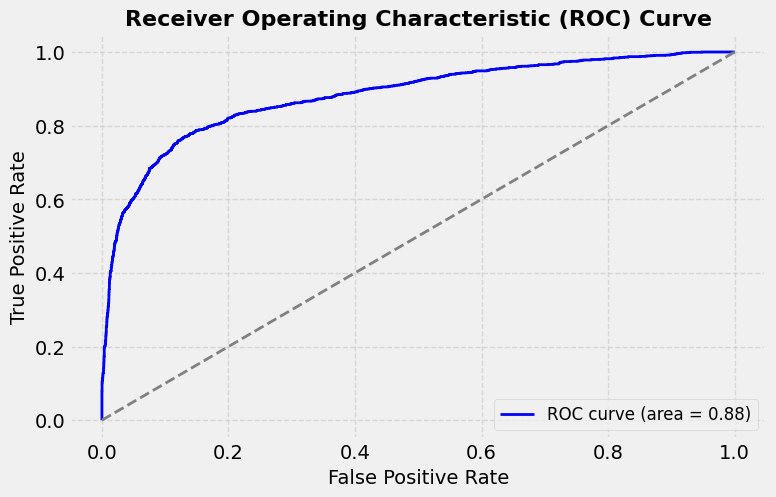

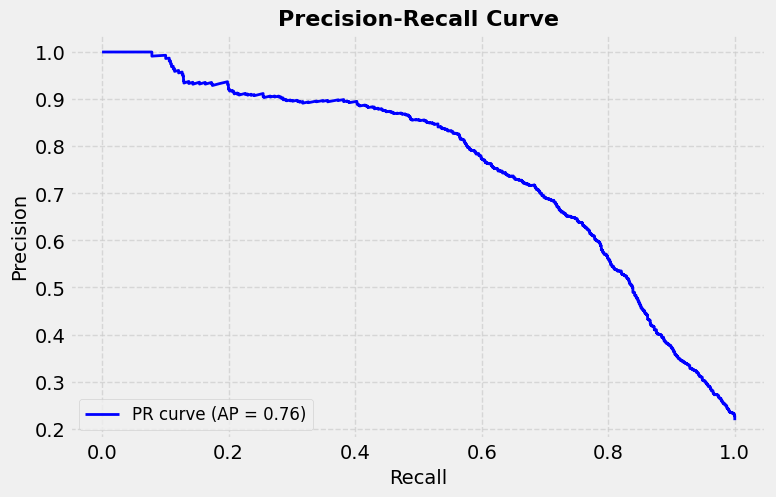

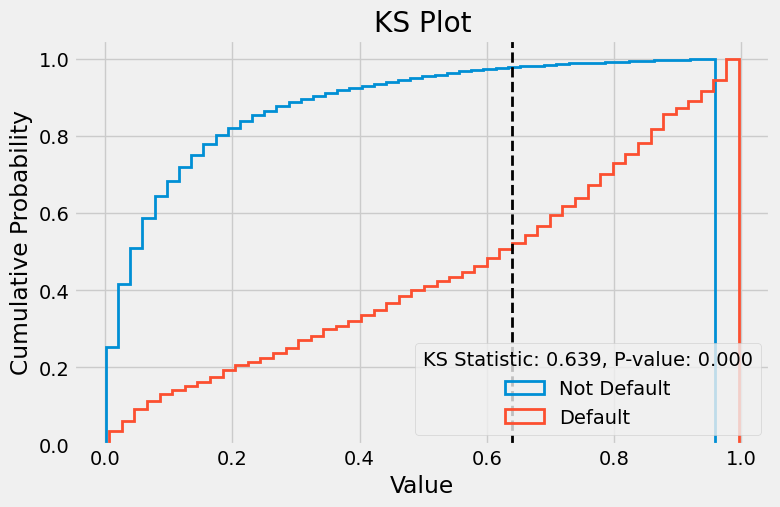

NameError: name 'calibration_curve' is not defined

In [115]:
X_test, y_test = test_woe.drop(columns=["loan_status"]), test_woe["loan_status"]
y_pred_proba = model.predict_proba(X_test[selected_features])[:, -1]
plot_roc_auc_curve(y_test, y_pred_proba)
plot_precision_recall_curve(y_test, y_pred_proba)
plot_ks(y_test, y_pred_proba)
plot_calibration_curve(y_test, y_pred_proba)

# Create Credit Scorecard

In [115]:
model_summary = pd.DataFrame({
    "Characteristic": selected_features,
    "Estimate": model.get_coefficient()
})

scorecards = pd.merge(
    right = woe_transformer.get_woe_df(), 
    left = model_summary,
    how = "left",
    on = ["Characteristic"]
)

scorecards

Characteristic  Estimate                 Value       WOE
0              person_age -0.357048        (19.999, 23.0] -0.121524
1              person_age -0.357048          (23.0, 26.0]  0.020734
2              person_age -0.357048          (26.0, 30.0]  0.069583
3              person_age -0.357048         (30.0, 144.0]  0.058225
4           person_income -0.968212  (3999.999, 38443.25] -0.862408
5           person_income -0.968212   (38443.25, 55000.0]  0.029862
6           person_income -0.968212    (55000.0, 79000.0]  0.319293
7           person_income -0.968212  (79000.0, 6000000.0]  1.009499
8   person_home_ownership -0.751689              MORTGAGE  0.679659
9   person_home_ownership -0.751689                 OTHER -0.549400
10  person_home_ownership -0.751689                   OWN  1.262009
11  person_home_ownership -0.751689                  RENT -0.507538
12      person_emp_length -0.253224         (-0.001, 2.0] -0.283750
13      person_emp_length -0.253224            (2.0, 4.0]  0.073195
14      person_emp_length -0.253224            (4.0, 7.0]  0.196157
15      person_emp_length -0.253224          (7.0, 123.0]  0.325354
16      person_emp_length -0.253224               Missing -0.521681
17            loan_intent -1.262798     DEBTCONSOLIDATION -0.323396
18            loan_intent -1.262798             EDUCATION  0.277027
19            loan_intent -1.262798       HOMEIMPROVEMENT -0.230444
20            loan_intent -1.262798               MEDICAL -0.272080
21            loan_intent -1.262798              PERSONAL  0.097897
22            loan_intent -1.262798               VENTURE  0.469865
23             loan_grade -1.150564                     A  0.918329
24             loan_grade -1.150564                     B  0.348345
25             loan_grade -1.150564                     C  0.081888
26             loan_grade -1.150564                     D -1.654452
27             loan_grade -1.150564                     E -1.854967
28             loan_grade -1.150564                     F -2.185571
29             loan_grade -1.150564                     G -5.037649
30              loan_amnt -0.842653     (499.999, 5000.0]  0.070919
31              loan_amnt -0.842653      (5000.0, 8000.0]  0.336055
32              loan_amnt -0.842653     (8000.0, 12000.0]  0.136723
33              loan_amnt -0.842653    (12000.0, 35000.0] -0.428565
34          loan_int_rate  0.004219          (5.419, 7.9]  0.973236
35          loan_int_rate  0.004219          (7.9, 10.99]  0.459663
36          loan_int_rate  0.004219        (10.99, 13.47]  0.156835
37          loan_int_rate  0.004219        (13.47, 22.48] -1.039311
38          loan_int_rate  0.004219               Missing  0.034578
39    loan_percent_income -0.771619        (-0.001, 0.09]  0.751099
40    loan_percent_income -0.771619          (0.09, 0.15]  0.661309
41    loan_percent_income -0.771619          (0.15, 0.23]  0.181253
42    loan_percent_income -0.771619          (0.23, 0.83] -1.139158

base_score = 1000, base_odds = 35 , pdo = 80, rate = 2

In [156]:
# Define Factor and Offset
factor = 80/np.log(2)
offset = 1000 - factor*np.log(35)

print(f"Factor = {factor:.2f} || Offset = {offset:.2f}")

Factor = 115.42 || Offset = 589.66


In [157]:
# Define n = number of characteristics
n = len(selected_features)

# Define b0
b0 = model.get_intercept()[0]

print(f"n = {n}")
print(f"b0 = {b0:.4f}")

n = 9
b0 = -0.0615


In [158]:
# Define beta and WOE
beta = scorecards['Estimate']
WOE = scorecards['WOE']

# Calculate the score point for each characteristic
scorecards['Points'] = (offset/n) - factor*((b0/n) + (beta*WOE))
scorecards['Points'] = scorecards['Points'].astype('int')

scorecards = scorecards.sort_values(by=["Characteristic", "Points"])

Credit score cards is useful for intepretability in operations of assessing creditworthines of an applicant.

In [159]:
# Create scorecard mapping
scorecard_features = scorecards["Characteristic"].unique()
scorecard_map_dict = {}

for feature in scorecard_features:
    scorecard_map_dict[feature] = scorecards[scorecards["Characteristic"]==feature].set_index("Value")["Points"].to_dict()

c:\Users\923006079\AppData\Local\anaconda3\envs\credit-risk-modelling\lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [160]:
# Function used to convert customer characteristics into credit points
def get_credit_points(value: Union[int, float, str], scorecard_map_dict: dict) -> float:
    """Tranform column values into credit points.

    Args:
        value (Union[int, float, str]): column value to be mapped to credit points.
        woe_dict_map (dict): dictionary containing the conditions (keys) and credit points (values).

    Returns:
        float: WOE value.
    """
    credit_points = None
    if pd.isna(value):
        credit_points = scorecard_map_dict.get("Missing", None)
    else:
        for interval, woe in scorecard_map_dict.items():
            if isinstance(interval, pd.Interval) and value in interval:
                credit_points = woe
    return credit_points

In [161]:
# Prepare input
input_df = df.sample(5)
credit_scores_df = pd.DataFrame({})
# train
for col in input_df.select_dtypes("number").columns:
    if col in scorecard_features:
        credit_scores_df[col+"_value"] = input_df[col].apply(lambda x: get_credit_points(x, scorecard_map_dict[col]))
        credit_scores_df[col+"_value"] = credit_scores_df[col+"_value"].fillna(scorecard_map_dict[col].get("Missing", np.nan))

for col in input_df.select_dtypes("object").columns:
    if col in scorecard_features:
        credit_scores_df[col+"_value"] = input_df[col].map(scorecard_map_dict[col])
        credit_scores_df[col+"_value"] = credit_scores_df[col+"_value"].fillna(scorecard_map_dict[col].get("Missing", np.nan))

credit_scores_df["credit_score"] = credit_scores_df.sum(axis=1)

In [162]:
levels_decriptions = {
    0: "Blacklist",
    1: "High Risk",
    2: "Medium Risk",
    3: "Moderate Risk",
    4: "Low Risk",
    5: "Normal Credit",
    6: "Good Credit",
    7: "Excellent Credit",
    8: "Perfect Credit"
}

def get_credit_levels(
    df: pd.DataFrame,
    target_col: str = "credit_score",
    left_bound = -100,
    level_0 = 100,
    level_1 = 200,
    level_2 = 250,
    level_3 = 300,
    level_4 = 350,
    level_5 = 400,
    level_6 = 450,
    level_7 = 500,
    level_8 = 800
) -> pd.DataFrame:
    """
    Explain the credit levels and description for all credit scores.

    Args:
        df (pd.DataFrame): The dataframe containing the credit score
        target_col (str): Column containing credit score.
        left_bound (int): Lowest possible credit score.
        level_0 (int): Value where the credit scores are equal or below will be categorize as level 0.
        level_1 (int): Value where the credit scores are equal or below will be categorize as level 1.
        level_2 (int): Value where the credit scores are equal or below will be categorize as level 2.
        level_3 (int): Value where the credit scores are equal or below will be categorize as level 3.
        level_4 (int): Value where the credit scores are equal or below will be categorize as level 4.
        level_5 (int): Value where the credit scores are equal or below will be categorize as level 5.
        level_6 (int): Value where the credit scores are equal or below will be categorize as level 6.
        level_7 (int): Value where the credit scores are equal or below will be categorize as level 7.
        level_8 (int): Value where the credit scores are equal or below will be categorize as level 8.
    Returns:
        float: The dataframe containing the credit levels and descriptions for all credit scores.
    """
    levels = []
    conditions = [
        (df[target_col] > left_bound) & (df[target_col] <= level_0),
        (df[target_col] > level_0) & (df[target_col] <= level_1),
        (df[target_col] > level_1) & (df[target_col] <= level_2),
        (df[target_col] > level_2) & (df[target_col] <= level_3),
        (df[target_col] > level_3) & (df[target_col] <= level_4),
        (df[target_col] > level_4) & (df[target_col] <= level_5),
        (df[target_col] > level_5) & (df[target_col] <= level_6),
        (df[target_col] > level_6) & (df[target_col] <= level_7),
        (df[target_col] > level_7) & (df[target_col] <= level_8)
    ]

    level_choices = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    lower_bound_choices = [left_bound, level_0, level_1, level_2, level_3, level_4, level_5, level_6, level_7]
    upper_bound_choices = [level_0, level_1, level_2, level_3, level_4, level_5, level_6, level_7, level_8]
    df["credit_level"] = np.select(conditions, level_choices)
    df["credit_lower_bound"] = np.select(conditions, lower_bound_choices)
    df["credit_upper_bound"] = np.select(conditions, upper_bound_choices)
    return df

## Present Results to User/ Management

In [163]:
# Create scorecard mapping
scorecard_features = scorecards["Characteristic"].unique()
scorecard_map_dict = {}

for feature in scorecard_features:
    scorecard_map_dict[feature] = scorecards[scorecards["Characteristic"]==feature].set_index("Value")["Points"].to_dict()

c:\Users\923006079\AppData\Local\anaconda3\envs\credit-risk-modelling\lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [164]:
# Function used to convert customer characteristics into credit points
def get_credit_points(value: Union[int, float, str], scorecard_map_dict: dict) -> float:
    """Tranform column values into credit points.

    Args:
        value (Union[int, float, str]): column value to be mapped to credit points.
        woe_dict_map (dict): dictionary containing the conditions (keys) and credit points (values).

    Returns:
        float: WOE value.
    """
    credit_points = None
    if pd.isna(value):
        credit_points = scorecard_map_dict.get("Missing", None)
    else:
        for interval, woe in scorecard_map_dict.items():
            if isinstance(interval, pd.Interval) and value in interval:
                credit_points = woe
    return credit_points

In [165]:
# Prepare input data
input_df = test.copy()
credit_scores_df = pd.DataFrame({})

for col in input_df.select_dtypes("number").columns:
    if col in scorecard_features:
        credit_scores_df[col+"_value"] = input_df[col].apply(lambda x: get_credit_points(x, scorecard_map_dict[col]))
        credit_scores_df[col+"_value"] = credit_scores_df[col+"_value"].fillna(scorecard_map_dict[col].get("Missing", np.nan))

for col in input_df.select_dtypes("object").columns:
    if col in scorecard_features:
        credit_scores_df[col+"_value"] = input_df[col].map(scorecard_map_dict[col])
        credit_scores_df[col+"_value"] = credit_scores_df[col+"_value"].fillna(scorecard_map_dict[col].get("Missing", np.nan))

credit_scores_df["credit_score"] = credit_scores_df.sum(axis=1)
credit_scores_df["credit_score"] = credit_scores_df["credit_score"].apply(lambda x: 1000 if x > 1000 else x)

In [166]:
credit_scores_df = get_credit_levels(credit_scores_df,
    target_col ='credit_score',
    left_bound = -1000,
    level_0 = 250,
    level_1 = 300,
    level_2 = 400,
    level_3 = 500,
    level_4 = 580,
    level_5 = 630,
    level_6 = 690,
    level_7 = 730,
    level_8 = 1000
)
credit_scores_df["credit_description"] = credit_scores_df["credit_level"].map(levels_decriptions)

In [167]:
report_df = credit_scores_df[["credit_score", "credit_level", "credit_lower_bound", "credit_upper_bound"]]
report_df["credit_description"] = report_df["credit_level"].map(levels_decriptions)
report_df["loan_status"] = test["loan_status"].values

C:\Users\923006079\AppData\Local\Temp\ipykernel_12628\672461742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  report_df["credit_description"] = report_df["credit_level"].map(levels_decriptions)
C:\Users\923006079\AppData\Local\Temp\ipykernel_12628\672461742.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  report_df["loan_status"] = test["loan_status"].values


In [168]:
report_agg_df = report_df\
    .groupby(["credit_level", "credit_lower_bound", "credit_upper_bound", "credit_description"])["loan_status"]\
    .value_counts()\
    .unstack()\
    .reset_index()\
    .rename(columns={
        0: "Not Default",
        1: "Default"
    })  # Calculate the occurence of good customers (not default) and bad customers (default)
report_agg_df = report_agg_df.rename_axis(None, axis=1)
report_agg_df["Customers"] = report_agg_df["Not Default"] + report_agg_df["Default"]
report_agg_df["Customers Rate"] = report_agg_df["Customers"] / report_agg_df["Customers"].sum() * 100  # percentage of customers exists in each credit levels
report_agg_df["Default Rate"] = report_agg_df["Default"] / report_agg_df["Customers"] * 100  # percentage of default for each credit levels
report_agg_df = report_agg_df[[
    "credit_level", "credit_lower_bound", "credit_upper_bound", 
    "credit_description", "Customers", "Customers Rate", 
    "Not Default", "Default", "Default Rate"]]\
    .rename(columns={
        "Not Default": "Good Customers", 
        "Default": "Bad Customers",
    })
report_agg_df["Reverse Cumulative Customers"] = report_agg_df["Customers"][::-1].cumsum()
report_agg_df["Reverse Cumulative Good Customers"] = report_agg_df["Good Customers"][::-1].cumsum()
report_agg_df["Reverse Cumulative Bad Customers"] = report_agg_df["Bad Customers"][::-1].cumsum()
report_agg_df["Good Customers Coverage"] = report_agg_df["Reverse Cumulative Good Customers"] / report_agg_df["Good Customers"].sum()  # Calculate the cumulative percentage of good customers covered from all customers
report_agg_df["Loss Coverage"] = report_agg_df["Reverse Cumulative Bad Customers"] / report_agg_df["Reverse Cumulative Customers"]  # Calculate the cumulative percentage of bad customers covered from the cumulative count of customers

With this, the management can perform calculation based on the risk they willing to take. For, example they wanted to cover at least **80% of Good Customers** and keeping **percentage of default below 10%**

In [169]:
report_agg_df[[
    "credit_level", "credit_lower_bound", "credit_upper_bound", 
    "credit_description", "Customers", "Customers Rate", 
    "Good Customers", "Bad Customers", "Default Rate",
    "Good Customers Coverage", "Loss Coverage"
]]

credit_level  credit_lower_bound  credit_upper_bound credit_description  \
0             0               -1000                 250          Blacklist   
1             1                 250                 300          High Risk   
2             2                 300                 400        Medium Risk   
3             3                 400                 500      Moderate Risk   
4             4                 500                 580           Low Risk   
5             5                 580                 630      Normal Credit   
6             6                 630                 690        Good Credit   
7             7                 690                 730   Excellent Credit   
8             8                 730                1000     Perfect Credit   

   Customers  Customers Rate  Good Customers  Bad Customers  Default Rate  \
0        251        3.851465              21            230     91.633466   
1        113        1.733927              21             92     81.415929   
2        391        5.999693             133            258     65.984655   
3        677       10.388215             333            344     50.812408   
4        688       10.557005             487            201     29.215116   
5        541        8.301366             468             73     13.493530   
6        686       10.526316             625             61      8.892128   
7        504        7.733620             456             48      9.523810   
8       2666       40.908393            2551            115      4.313578   

   Good Customers Coverage  Loss Coverage  
0                 1.000000       0.218199  
1                 0.995878       0.190233  
2                 0.991757       0.178775  
3                 0.965653       0.146130  
4                 0.900294       0.097935  
5                 0.804711       0.067546  
6                 0.712856       0.058091  
7                 0.590186       0.051420  
8                 0.500687       0.043136

## Explanation
1. Based on the Coverage Table, it would be a great idea to accept those who has **credit level of 6 to 8** to cover at least 80% of Good Customers, but the the consequence of accepting level 6 and above is the loss of almost **6.8%** of the accepted applicant.
2. Turns out you can push the limits with accepting those with at least has a **credit level of 5**/ categorize as `Low Risk` customers with the loss of **9.8%** of the accepted applicant.